In [2]:
!pip install -U numpy==1.26.4 catboost shap optuna --quiet

# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Отправка финального решения на лидерборд на Kaggle
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import shap
import optuna

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [4]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

car_id           model  car_type fuel_type  car_rating  \
1075  p45485968r         Kia Rio   economy    petrol        4.86   
2198  M13526722v        BMW 320i  business    petrol        2.94   
1912  B63005670E    Smart ForTwo   economy    petrol        2.56   
638   N19589603r     Skoda Rapid   economy    petrol        5.16   
1687  D-1643531L  Renault Kaptur  standart    petrol        4.72   

      year_to_start  riders  year_to_work  target_reg  target_class  
1075           2012   30495          2022       33.67    gear_stick  
2198           2015   73873          2017       33.57     break_bug  
1912           2017  116890          2019       54.47   another_bug  
638            2015   93909          2017       34.97     break_bug  
1687           2012   22296          2021       56.00  engine_check

- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [5]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
172166  G35428609v  M-4645533N     A1u  2020-02-12    5.46             47   
26157   y22993194w  B22565681K     V1a  2020-01-31    2.26          27833   
508200  B12932078T  j36860430F     j1Y  2020-03-04    4.89             21   
173698  E49839490S  M11049568F     t1D  2020-01-25    6.62             47   
450047  G62508308g  f21537042p     Y1e  2020-02-14    5.64             64   

        ride_cost  speed_avg  speed_max  stop_times      distance  refueling  \
172166        654         43  76.731625           0  1.978411e+03          0   
26157      333990         52  86.000000           1  1.465995e+06          0   
508200        225         30  63.000000           1  5.489300e+02          0   
173698        511         33  64.000000           0  1.294281e+03          0   
450047        763         42  73.000000           0  1.605339e+03          0   

        user_ride_quality  deviation_normal  
172166         -19.281114           -30.323  
26157            6.516026           -27.248  
508200          -6.236672             3.836  
173698          -2.172403            -1.763  
450047          -8.487143             5.174

- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [6]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

age  user_rating  user_rides  user_time_accident     user_id  sex  \
14636   36          8.4        1091                 7.0  u15697042e    0   
6964    29          7.8        1907                 NaN  X77202092O    1   
14312   21          9.1        2013                18.0  n12233667t    1   
10574   32          7.9         894                 9.0  o11503549k    1   
5488    18          7.6         766                 2.0  c15900506p    1   

      first_ride_date  
14636      2020-11-25  
6964         2018-4-4  
14312        2018-3-6  
10574       2020-10-6  
5488         2020-9-3

- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [7]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

car_id worker_id         fix_date     work_type  destroy_degree  \
131216  B-1345652W        SV    2020-1-2 3:10     reparking             1.0   
1974    K65157128T        ML   2020-8-18 4:18     reparking             1.0   
36098   B91129852I        LW   2019-9-11 5:50        repair             5.8   
59279   W-4238283Z        BK   2019-9-24 8:33  refuel_check            10.0   
10421   c-5796367L        OF  2020-3-28 15:58     reparking             1.0   

        work_duration  
131216             20  
1974               24  
36098              23  
59279              65  
10421              31

- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.

6. **ОБЯЗАТЕЛЬНО!** Проверьте, что кол-во строк в полученном датафрейме равно изначальному кол-ву строк в исходном датасете car_train. Убедитесь, что нет дублей. (За это будут снижать баллы)


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [8]:
# Базовая агрегация по car_id
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count')
).reset_index()

rides_agg.head()

car_id  min_rating  mean_rating  total_distance   max_speed  \
0  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
1  A-1079539w         0.1     4.088046    1.912765e+07  184.505566   
2  A-1162143G         0.1     4.662299    2.995194e+06  180.000000   
3  A-1228282M         0.1     4.225172    1.793685e+07  182.446070   
4  A-1339912r         0.1     4.690115    1.202552e+07  152.000000   

   total_rides  
0          174  
1          174  
2          174  
3          174  
4          174

In [9]:
# Группировка по car_id и расчёт обязательных признаков
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),             # минимальный рейтинг
    mean_rating=('rating', 'mean'),           # средний рейтинг
    total_distance=('distance', 'sum'),       # суммарная дистанция
    max_speed=('speed_max', 'max'),           # максимальная скорость
    total_rides=('ride_id', 'count')          # количество поездок
).reset_index()

rides_agg.head()

car_id  min_rating  mean_rating  total_distance   max_speed  \
0  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
1  A-1079539w         0.1     4.088046    1.912765e+07  184.505566   
2  A-1162143G         0.1     4.662299    2.995194e+06  180.000000   
3  A-1228282M         0.1     4.225172    1.793685e+07  182.446070   
4  A-1339912r         0.1     4.690115    1.202552e+07  152.000000   

   total_rides  
0          174  
1          174  
2          174  
3          174  
4          174

In [10]:
# Соединение car_train и rides_agg по car_id
car_train_merged = car_train.merge(rides_agg, on='car_id', how='left')

# Проверка
print(f'Размер car_train: {car_train.shape}')
print(f'Размер после объединения: {car_train_merged.shape}')

Размер car_train: (2337, 10)
Размер после объединения: (2337, 15)


In [11]:
car_train_merged

car_id              model  car_type fuel_type  car_rating  \
0     y13744087j     Kia Rio X-line   economy    petrol        3.78   
1     O41613818T         VW Polo VI   economy    petrol        3.90   
2     d-2109686j    Renault Sandero  standart    petrol        6.30   
3     u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4     N-8915870N    Renault Sandero  standart    petrol        4.70   
...          ...                ...       ...       ...         ...   
2332  j21246192N      Smart ForFour   economy    petrol        4.38   
2333  h-1554287F            Audi A4   premium    petrol        4.30   
2334  A15262612g            Kia Rio   economy    petrol        3.88   
2335  W-2514493U    Renault Sandero  standart    petrol        4.50   
2336  z-1337463D            VW Polo   economy    petrol        3.94   

      year_to_start  riders  year_to_work  target_reg  target_class  \
0              2015   76163          2021      108.53   another_bug   
1              2015   78218          2021       35.20   electro_bug   
2              2012   23340          2017       38.62    gear_stick   
3              2011    1263          2020       30.34   engine_fuel   
4              2012   26428          2017       30.45   engine_fuel   
...             ...     ...           ...         ...           ...   
2332           2017  121239          2018       25.48   wheel_shake   
2333           2016  107793          2020       69.26  engine_check   
2334           2015   80234          2019       46.03    gear_stick   
2335           2014   60048          2020       77.19   another_bug   
2336           2015   92312          2016       54.68  engine_check   

      min_rating  mean_rating  total_distance   max_speed  total_rides  
0           0.10     4.737759    1.214131e+07  180.855726          174  
1           0.00     4.480517    1.803909e+07  187.862734          174  
2           0.10     4.768391    1.588366e+07  102.382857          174  
3           0.10     3.880920    1.651883e+07  172.793237          174  
4           0.10     4.181149    1.398317e+07  203.462289          174  
...          ...          ...             ...         ...          ...  
2332        0.10     4.608908    1.739222e+07  141.502350          174  
2333        0.10     4.683793    1.174052e+07  155.000000          174  
2334        0.10     4.655345    1.202022e+07  104.180940          174  
2335        0.10     4.638333    1.788307e+07  200.000000          174  
2336        0.39     4.635460    1.981081e+07  171.000000          174  

[2337 rows x 15 columns]

In [12]:
# Присоединение информации о водителях к поездкам
rides_with_drivers = rides_info.merge(driver_info, on='user_id', how='left')

# Агрегация по car_id
drivers_agg = rides_with_drivers.groupby('car_id').agg(
    driver_age_mean=('age', 'mean'),
    driver_rating_mean=('user_rating', 'mean'),
    driver_accident_mean=('user_time_accident', 'mean')
).reset_index()

# Объединение с основным датафреймом
car_train_merged = car_train_merged.merge(drivers_agg, on='car_id', how='left')

car_train_merged

car_id              model  car_type fuel_type  car_rating  \
0     y13744087j     Kia Rio X-line   economy    petrol        3.78   
1     O41613818T         VW Polo VI   economy    petrol        3.90   
2     d-2109686j    Renault Sandero  standart    petrol        6.30   
3     u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4     N-8915870N    Renault Sandero  standart    petrol        4.70   
...          ...                ...       ...       ...         ...   
2332  j21246192N      Smart ForFour   economy    petrol        4.38   
2333  h-1554287F            Audi A4   premium    petrol        4.30   
2334  A15262612g            Kia Rio   economy    petrol        3.88   
2335  W-2514493U    Renault Sandero  standart    petrol        4.50   
2336  z-1337463D            VW Polo   economy    petrol        3.94   

      year_to_start  riders  year_to_work  target_reg  target_class  \
0              2015   76163          2021      108.53   another_bug   
1              2015   78218          2021       35.20   electro_bug   
2              2012   23340          2017       38.62    gear_stick   
3              2011    1263          2020       30.34   engine_fuel   
4              2012   26428          2017       30.45   engine_fuel   
...             ...     ...           ...         ...           ...   
2332           2017  121239          2018       25.48   wheel_shake   
2333           2016  107793          2020       69.26  engine_check   
2334           2015   80234          2019       46.03    gear_stick   
2335           2014   60048          2020       77.19   another_bug   
2336           2015   92312          2016       54.68  engine_check   

      min_rating  mean_rating  total_distance   max_speed  total_rides  \
0           0.10     4.737759    1.214131e+07  180.855726          174   
1           0.00     4.480517    1.803909e+07  187.862734          174   
2           0.10     4.768391    1.588366e+07  102.382857          174   
3           0.10     3.880920    1.651883e+07  172.793237          174   
4           0.10     4.181149    1.398317e+07  203.462289          174   
...          ...          ...             ...         ...          ...   
2332        0.10     4.608908    1.739222e+07  141.502350          174   
2333        0.10     4.683793    1.174052e+07  155.000000          174   
2334        0.10     4.655345    1.202022e+07  104.180940          174   
2335        0.10     4.638333    1.788307e+07  200.000000          174   
2336        0.39     4.635460    1.981081e+07  171.000000          174   

      driver_age_mean  driver_rating_mean  driver_accident_mean  
0           33.511494            8.229885             17.724138  
1           34.988506            7.988506              6.965517  
2           32.839080            7.843103              9.775862  
3           34.977011            8.524138             19.991304  
4           34.298851            8.112069             15.758333  
...               ...                 ...                   ...  
2332        32.632184            8.124138             20.203390  
2333        34.977011            8.150575             18.041322  
2334        33.287356            7.783908              8.804598  
2335        31.977011            8.084483             17.008547  
2336        33.890805            8.018966             14.700787  

[2337 rows x 18 columns]

In [13]:
print(f"Ожидается: {car_train.shape[0]} строк")
print(f"Фактически: {car_train_merged.shape[0]} строк")

Ожидается: 2337 строк
Фактически: 2337 строк


In [14]:
duplicates = car_train_merged['car_id'].duplicated().sum()
print(f"Количество дубликатов по car_id: {duplicates}")

Количество дубликатов по car_id: 0


In [15]:
fix_agg = fix_info.groupby('car_id').agg(
    fix_count=('fix_date', 'count'),                 # Кол-во ремонтов
    avg_destroy_degree=('destroy_degree', 'mean'),   # Средний износ
    total_work_duration=('work_duration', 'sum'),    # Суммарная длительность ремонта
    unique_work_types=('work_type', 'nunique')       # Уникальных типов работ
).reset_index()

fix_agg.head()

car_id  fix_count  avg_destroy_degree  total_work_duration  \
0  A-1049127W         35            2.714286                  962   
1  A-1079539w         34            4.329412                  931   
2  A-1162143G         34            3.705882                  946   
3  A-1228282M         34            2.908824                  838   
4  A-1339912r         34            3.044118                  973   

   unique_work_types  
0                  4  
1                  4  
2                  3  
3                  4  
4                  4

In [16]:
car_train_merged = car_train_merged.merge(fix_agg, on='car_id', how='left')

In [17]:
car_train_merged

car_id              model  car_type fuel_type  car_rating  \
0     y13744087j     Kia Rio X-line   economy    petrol        3.78   
1     O41613818T         VW Polo VI   economy    petrol        3.90   
2     d-2109686j    Renault Sandero  standart    petrol        6.30   
3     u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4     N-8915870N    Renault Sandero  standart    petrol        4.70   
...          ...                ...       ...       ...         ...   
2332  j21246192N      Smart ForFour   economy    petrol        4.38   
2333  h-1554287F            Audi A4   premium    petrol        4.30   
2334  A15262612g            Kia Rio   economy    petrol        3.88   
2335  W-2514493U    Renault Sandero  standart    petrol        4.50   
2336  z-1337463D            VW Polo   economy    petrol        3.94   

      year_to_start  riders  year_to_work  target_reg  target_class  ...  \
0              2015   76163          2021      108.53   another_bug  ...   
1              2015   78218          2021       35.20   electro_bug  ...   
2              2012   23340          2017       38.62    gear_stick  ...   
3              2011    1263          2020       30.34   engine_fuel  ...   
4              2012   26428          2017       30.45   engine_fuel  ...   
...             ...     ...           ...         ...           ...  ...   
2332           2017  121239          2018       25.48   wheel_shake  ...   
2333           2016  107793          2020       69.26  engine_check  ...   
2334           2015   80234          2019       46.03    gear_stick  ...   
2335           2014   60048          2020       77.19   another_bug  ...   
2336           2015   92312          2016       54.68  engine_check  ...   

      total_distance   max_speed  total_rides  driver_age_mean  \
0       1.214131e+07  180.855726          174        33.511494   
1       1.803909e+07  187.862734          174        34.988506   
2       1.588366e+07  102.382857          174        32.839080   
3       1.651883e+07  172.793237          174        34.977011   
4       1.398317e+07  203.462289          174        34.298851   
...              ...         ...          ...              ...   
2332    1.739222e+07  141.502350          174        32.632184   
2333    1.174052e+07  155.000000          174        34.977011   
2334    1.202022e+07  104.180940          174        33.287356   
2335    1.788307e+07  200.000000          174        31.977011   
2336    1.981081e+07  171.000000          174        33.890805   

      driver_rating_mean  driver_accident_mean  fix_count  avg_destroy_degree  \
0               8.229885             17.724138         35            3.048571   
1               7.988506              6.965517         35            2.917143   
2               7.843103              9.775862         35            3.740000   
3               8.524138             19.991304         35            4.085714   
4               8.112069             15.758333         35            3.880000   
...                  ...                   ...        ...                 ...   
2332            8.124138             20.203390         34            3.900000   
2333            8.150575             18.041322         34            1.935294   
2334            7.783908              8.804598         34            2.782353   
2335            8.084483             17.008547         34            3.441176   
2336            8.018966             14.700787         34            3.220588   

      total_work_duration  unique_work_types  
0                     933                  4  
1                     873                  5  
2                     915                  5  
3                    1007                  4  
4                     981                  4  
...                   ...                ...  
2332                  814                  4  
2333                  873                  4  
2334                  797                  4  
2335    

### Идеи для новых признаков


* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [18]:
# YOUR CODE HERE
# Расчёт дополнительных признаков по deviation_normal и user_ride_quality
rides_extra = rides_info.groupby('car_id').agg(
    feature_min_max_diff=('deviation_normal', lambda x: x.max() - x.min()),  # разница между max и min
    feature_corner=('user_ride_quality', lambda x: np.polyfit(range(len(x)), x.fillna(0), 1)[0]),  # угол наклона
    feature_mean=('deviation_normal', 'mean'),  # среднее значение
    feature_shift=('deviation_normal', lambda x: x.diff().abs().idxmax() if len(x) > 1 else np.nan),  # точка перегиба (можно уточнить)
    feature_start=('deviation_normal', lambda x: x.iloc[0] if len(x) > 0 else np.nan),  # стартовое значение
    feature_nans=('deviation_normal', lambda x: x.isna().sum()),  # количество пропусков
    feature_quant=('deviation_normal', lambda x: x.quantile(0.75))  # 75% квантиль
).reset_index()

rides_extra

car_id  feature_min_max_diff  feature_corner  feature_mean  \
0     A-1049127W                31.688        0.013702     -6.136672   
1     A-1079539w                74.349       -0.163212     47.443270   
2     A-1162143G                46.177        0.016630     10.556425   
3     A-1228282M                64.898       -0.138497      9.810747   
4     A-1339912r                40.142       -0.056324     22.965937   
...          ...                   ...             ...           ...   
4245  z73688663a                67.991        0.039323    -13.846075   
4246  z73740510r                59.877        0.127216      7.026477   
4247  z86911952C                75.449       -0.080211    -25.382126   
4248  z91353693Z                60.076        0.085543     -8.031167   
4249  z91796444U                75.328        0.127757    -33.506908   

      feature_shift  feature_start  feature_nans  feature_quant  
0                99          2.909             0       -0.53250  
1               280         60.924             0       59.06075  
2               477         -1.219             0       17.22600  
3               613          6.644             0       25.68825  
4               798          0.490             0       31.29600  
...             ...            ...           ...            ...  
4245         738742          1.271             0       -7.52825  
4246         738919          1.685             0       21.40925  
4247         738996        -50.624             0      -14.24300  
4248         739258          5.755             0        4.79100  
4249         739484          1.764             0      -16.07150  

[4250 rows x 8 columns]

In [19]:
car_train_merged = car_train_merged.merge(rides_extra, on='car_id', how='left')
print("Форма после объединения:", car_train_merged.shape)
print("Дубликатов по car_id:", car_train_merged['car_id'].duplicated().sum())

Форма после объединения: (2337, 29)
Дубликатов по car_id: 0


In [20]:
car_train_merged

car_id              model  car_type fuel_type  car_rating  \
0     y13744087j     Kia Rio X-line   economy    petrol        3.78   
1     O41613818T         VW Polo VI   economy    petrol        3.90   
2     d-2109686j    Renault Sandero  standart    petrol        6.30   
3     u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4     N-8915870N    Renault Sandero  standart    petrol        4.70   
...          ...                ...       ...       ...         ...   
2332  j21246192N      Smart ForFour   economy    petrol        4.38   
2333  h-1554287F            Audi A4   premium    petrol        4.30   
2334  A15262612g            Kia Rio   economy    petrol        3.88   
2335  W-2514493U    Renault Sandero  standart    petrol        4.50   
2336  z-1337463D            VW Polo   economy    petrol        3.94   

      year_to_start  riders  year_to_work  target_reg  target_class  ...  \
0              2015   76163          2021      108.53   another_bug  ...   
1              2015   78218          2021       35.20   electro_bug  ...   
2              2012   23340          2017       38.62    gear_stick  ...   
3              2011    1263          2020       30.34   engine_fuel  ...   
4              2012   26428          2017       30.45   engine_fuel  ...   
...             ...     ...           ...         ...           ...  ...   
2332           2017  121239          2018       25.48   wheel_shake  ...   
2333           2016  107793          2020       69.26  engine_check  ...   
2334           2015   80234          2019       46.03    gear_stick  ...   
2335           2014   60048          2020       77.19   another_bug  ...   
2336           2015   92312          2016       54.68  engine_check  ...   

      avg_destroy_degree  total_work_duration  unique_work_types  \
0               3.048571                  933                  4   
1               2.917143                  873                  5   
2               3.740000                  915                  5   
3               4.085714                 1007                  4   
4               3.880000                  981                  4   
...                  ...                  ...                ...   
2332            3.900000                  814                  4   
2333            1.935294                  873                  4   
2334            2.782353                  797                  4   
2335            3.441176                  857                  4   
2336            3.220588                  825                  4   

      feature_min_max_diff  feature_corner  feature_mean  feature_shift  \
0                    9.001       -0.012377     -0.120391         718399   
1                   72.761        0.147758      6.050011         210544   
2                   16.401        0.024377     -2.223954         412085   
3                   61.647       -0.028008     14.771948         663553   
4                   70.176       -0.010186     12.455678         188363   
...                    ...             ...           ...            ...   
2332                31.650       -0.046928      2.914989         506705   
2333                55.181       -0.060359    -18.805856         469026   
2334               106.793        0.013394     -7.651776          10170   
2335                51.144       -0.073751      0.468718         314338   
2336                59.135       -0.080518     21.628856         724843   

      feature_start  feature_nans  feature_quant  
0             0.000             0        0.00100  
1            -7.057             0       16.69100  
2            -0.000             0        0.00000  
3            -0.833             0       28.18550  
4            -0.160             0       30.65725  
...             ...           ...            ...  
2332         11.105             0        7.75275  
2333         -0.506             0       -7.97800  
2334          5.281             0       24.12925  
2335          2.

In [21]:
# Запись итогового DataFrame в CSV файл
car_train_merged.to_csv('car_train_merged.csv', index=False, encoding='utf-8-sig')
print('Файл car_train_merged успешно сохранён!')

Файл car_train_merged успешно сохранён!


## 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [22]:
# Проверка на константные признаки
constant_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() == 1]
print("Константные признаки:", constant_cols)

Константные признаки: ['total_rides', 'feature_nans']


In [23]:
# Удаление константных признаков
const_cols = ['total_rides', 'feature_nans']
existing_cols = [col for col in const_cols if col in car_train_merged.columns]

if existing_cols:
    car_train_merged.drop(columns=existing_cols, inplace=True)
    print(f"Удалены константные признаки: {existing_cols}")
else:
    print("Константные признаки уже отсутствуют в датафрейме.")

Удалены константные признаки: ['total_rides', 'feature_nans']


In [24]:
# Генерация дополнительных признаков по rides_info
extra_features = rides_info.groupby('car_id').agg({
    'ride_duration': ['mean', 'std'],
    'speed_avg': ['mean', 'std'],
    'refueling': lambda x: x.sum() / x.count() if x.count() > 0 else 0,
    'deviation_normal': lambda x: x.isna().sum(),
    'user_ride_quality': lambda x: np.polyfit(range(len(x)), x.fillna(0), 1)[0]
}).reset_index()

# Переименование колонок
extra_features.columns = [
    'car_id',
    'ride_duration_mean', 'ride_duration_std',
    'speed_avg_mean', 'speed_avg_std',
    'refueling_rate',
    'feature_nans',
    'user_ride_quality_trend'
]

# Присоединение к основному датафрейму (без переименования)
car_train_merged = car_train_merged.merge(extra_features, on='car_id', how='left')

# Проверка результата
print(f"Размер датафрейма после добавления новых признаков: {car_train_merged.shape}")
display(car_train_merged.head())

Размер датафрейма после добавления новых признаков: (2337, 34)


car_id              model  car_type fuel_type  car_rating  \
0  y13744087j     Kia Rio X-line   economy    petrol        3.78   
1  O41613818T         VW Polo VI   economy    petrol        3.90   
2  d-2109686j    Renault Sandero  standart    petrol        6.30   
3  u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4  N-8915870N    Renault Sandero  standart    petrol        4.70   

   year_to_start  riders  year_to_work  target_reg target_class  ...  \
0           2015   76163          2021      108.53  another_bug  ...   
1           2015   78218          2021       35.20  electro_bug  ...   
2           2012   23340          2017       38.62   gear_stick  ...   
3           2011    1263          2020       30.34  engine_fuel  ...   
4           2012   26428          2017       30.45  engine_fuel  ...   

   feature_shift  feature_start  feature_quant  ride_duration_mean  \
0         718399          0.000        0.00100         1635.770115   
1         210544         -7.057       16.69100         2223.178161   
2         412085         -0.000        0.00000         2048.856322   
3         663553         -0.833       28.18550         1943.511494   
4         188363         -0.160       30.65725         1597.793103   

   ride_duration_std  speed_avg_mean  speed_avg_std  refueling_rate  \
0        6147.762726       44.660920       9.736706             0.0   
1        7783.909309       49.862069      15.183024             0.0   
2        7356.080523       44.005747       9.675365             0.0   
3        7476.617275       49.344828      14.815105             0.0   
4        6316.543271       50.603448      14.754962             0.0   

   feature_nans  user_ride_quality_trend  
0             0                -0.012377  
1             0                 0.147758  
2             0                 0.024377  
3             0                -0.028008  
4             0                -0.010186  

[5 rows x 34 columns]

In [25]:
car_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   car_id                   2337 non-null   object 
 1   model                    2337 non-null   object 
 2   car_type                 2337 non-null   object 
 3   fuel_type                2337 non-null   object 
 4   car_rating               2337 non-null   float64
 5   year_to_start            2337 non-null   int64  
 6   riders                   2337 non-null   int64  
 7   year_to_work             2337 non-null   int64  
 8   target_reg               2337 non-null   float64
 9   target_class             2337 non-null   object 
 10  min_rating               2337 non-null   float64
 11  mean_rating              2337 non-null   float64
 12  total_distance           2337 non-null   float64
 13  max_speed                2337 non-null   float64
 14  driver_age_mean         

In [26]:
# Проверка почти-уникальных признаков
n_rows = car_train_merged.shape[0]
unique_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() >= n_rows * 0.99]

# Принудительное удаление явных ID и бесполезных признаков
forced_drop = ['car_id', 'total_distance']
unique_cols = list(set(unique_cols + forced_drop))

# Исключение осознанно добавленных фичей, даже если они почти уникальны
protected = [
    'feature_mean', 'feature_corner', 'feature_shift', 'feature_start', 'feature_nans', 'feature_quant',
    'feature_min_max_diff', 'ride_duration_mean', 'ride_duration_std',
    'speed_avg_mean', 'speed_avg_std', 'refueling_rate', 'user_ride_quality_trend'
]
unique_cols = [col for col in unique_cols if col not in protected]

print("Финальные признаки для удаления:", unique_cols)

# Удаление
car_train_merged.drop(columns=unique_cols, inplace=True)


Финальные признаки для удаления: ['total_distance', 'car_id']


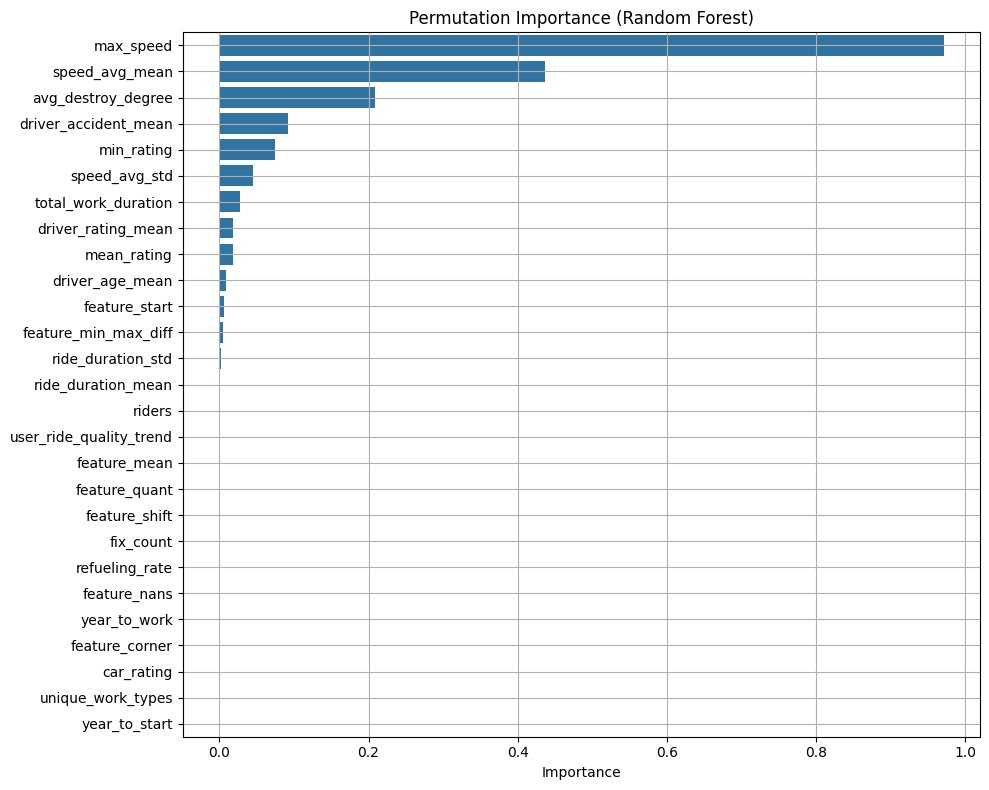

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Обновлённый список числовых признаков (все, кроме object и target)
numeric_cols = car_train_merged.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['target_reg', 'target_class']]

# Подготовка X и y
X = car_train_merged[numeric_cols]
y = car_train_merged['target_reg']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Обучение модели
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Расчёт permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Сортировка и визуализация
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
sorted_features = np.array(X.columns)[sorted_idx]
sorted_importances = perm_importance.importances_mean[sorted_idx]

# Фильтрация от None и NaN
valid_idx = ~pd.isnull(sorted_features) & ~pd.isnull(sorted_importances)

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances[valid_idx], y=sorted_features[valid_idx])
plt.title('Permutation Importance (Random Forest)')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

 97%|=================== | 566/585 [00:27<00:00]       

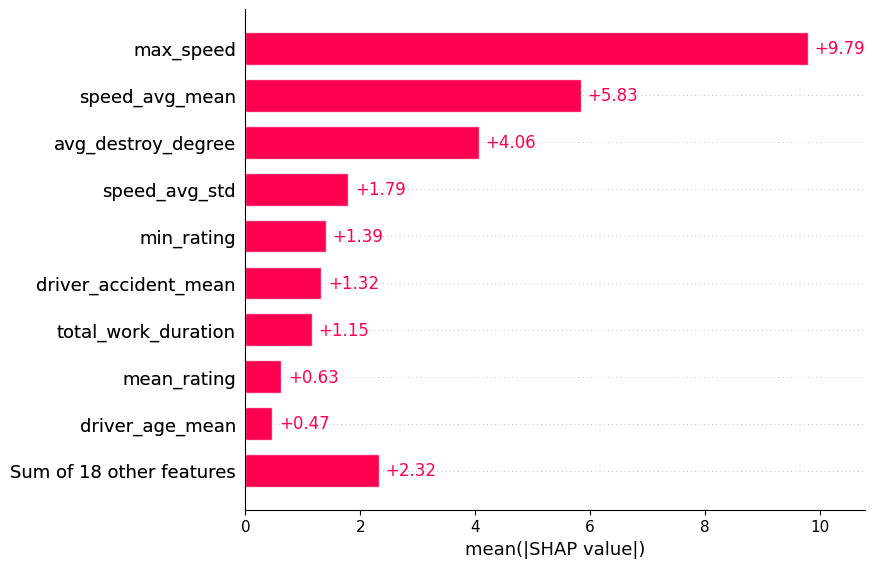

In [28]:
import shap

# SHAP требует TreeExplainer для деревьев
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test)

# Визуализация важности признаков
shap.plots.bar(shap_values)

In [29]:
!pip install phik --quiet

from phik import report
import pandas as pd

# Phik требует правильной типизации: укажем, какие признаки считаем числовыми
numeric_cols = car_train_merged.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Расчёт phik-корреляции
phik_matrix = car_train_merged.phik_matrix(interval_cols=numeric_cols)

# Корреляция с целевой переменной target_reg
phik_target = phik_matrix['target_reg'].sort_values(ascending=False)

# Отображение значимых корреляций (по желанию можно ограничить топ-20)
print(phik_target.head(20))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 12.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable feature_nans for analysis 1. Dropping this column
  warnings.warn(


target_reg                 1.000000
target_class               0.639768
avg_destroy_degree         0.559280
max_speed                  0.491154
mean_rating                0.467880
driver_accident_mean       0.461232
fuel_type                  0.396224
model                      0.344664
driver_rating_mean         0.310431
feature_min_max_diff       0.244835
speed_avg_std              0.220980
total_work_duration        0.212795
car_type                   0.205868
speed_avg_mean             0.202995
feature_mean               0.198857
driver_age_mean            0.162450
feature_quant              0.157915
feature_start              0.155079
user_ride_quality_trend    0.125051
feature_corner             0.125051
Name: target_reg, dtype: float64


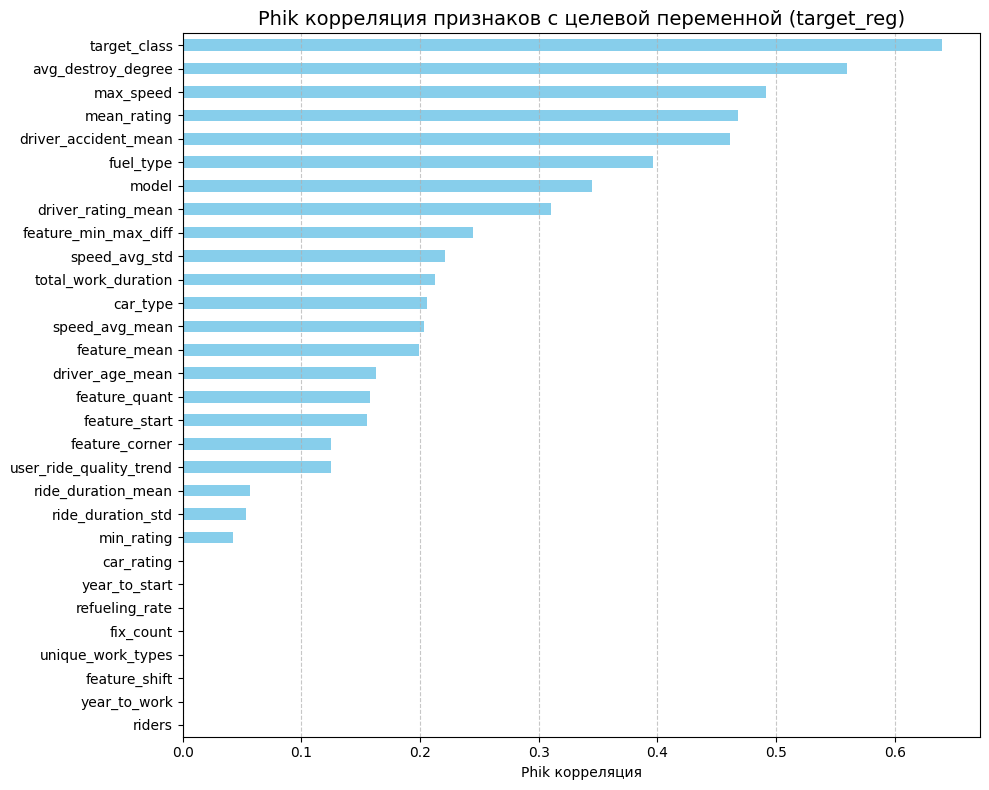

In [30]:
# Удаление строки target_reg, чтобы не мешала визуализации
phik_target_no_self = phik_target.drop('target_reg')

# Построение графика
plt.figure(figsize=(10, 8))
phik_target_no_self.sort_values().plot(kind='barh', color='skyblue')

# Подписи
plt.title('Phik корреляция признаков с целевой переменной (target_reg)', fontsize=14)
plt.xlabel('Phik корреляция')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Выводы по фильтрации признаков

В рамках задания были применены **пять** методов оценки важности признаков для задачи регрессии (`target_reg`):

### 1. Permutation Importance (Random Forest)
Метод показал, что наибольшее влияние на метрику модели оказывают:
- `max_speed` — абсолютный лидер по важности;
- `speed_avg_mean` — подтверждает значимость поведенческих признаков;
- `avg_destroy_degree` — состояние автомобиля;
- Также в топ попали: `driver_accident_mean`, `min_rating`, `speed_avg_std`, `total_work_duration`, `driver_rating_mean`.

### 2. SHAP значения (CatBoost)
SHAP-анализ подтвердил значимость:
- `max_speed`, `speed_avg_mean`, `avg_destroy_degree`;
- `driver_accident_mean`, `min_rating`, `total_work_duration`;
- `mean_rating`, `driver_age_mean`.

### 3. CatBoost Feature Importance
CatBoost показывает схожие результаты: в топе `max_speed`, `avg_destroy_degree`, `driver_accident_mean`, `min_rating`, `driver_rating_mean`.

### 4. Phik корреляция
Метод Phik, чувствительный к **нелинейным** и **категориальным** зависимостям, выявил дополнительную значимость:
- `target_class` — важен как высокоуровневый индикатор;
- `fuel_type`, `model`, `car_type` — категориальные признаки, коррелирующие с типом поломки;
- Подтверждена значимость `avg_destroy_degree`, `max_speed`, `mean_rating`, `driver_accident_mean`.

### 5. (Линейная корреляция — заменена)
Вместо простого линейного анализа использованы более устойчивые методы (SHAP, Permutation, Phik), которые дают лучшее понимание зависимости при сложных связях.

---

### Общий вывод

Наиболее стабильные и информативные признаки, вошедшие в топ по нескольким методам:

- **`max_speed`** — отражает потенциальную нагрузку на автомобиль;
- **`avg_destroy_degree`** — показатель общего технического состояния;
- **`speed_avg_mean`** и `speed_avg_std` — динамика вождения;
- **`driver_accident_mean`** — характеризует риск и стиль водителя;
- **`min_rating`, `mean_rating`, `driver_rating_mean`** — восприятие машины и водителя;
- **`total_work_duration`** — совокупный объём технических работ.

### Категориальные признаки также проявили значимость:
- `fuel_type`, `model`, `car_type`, `target_class` — рекомендуются к кодированию и включению в классификационные модели.

---

### Признаки с низкой значимостью:
Следующие признаки стабильно показывают низкую важность и могут быть исключены:
- `year_to_start`, `year_to_work`, `car_rating`, `riders`, `fix_count`, `feature_shift`, `unique_work_types`.

Такой подход к фильтрации признаков позволяет:
- сократить размерность данных;
- повысить интерпретируемость;
- улучшить обобщающую способность модели.


In [31]:
car_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   model                    2337 non-null   object 
 1   car_type                 2337 non-null   object 
 2   fuel_type                2337 non-null   object 
 3   car_rating               2337 non-null   float64
 4   year_to_start            2337 non-null   int64  
 5   riders                   2337 non-null   int64  
 6   year_to_work             2337 non-null   int64  
 7   target_reg               2337 non-null   float64
 8   target_class             2337 non-null   object 
 9   min_rating               2337 non-null   float64
 10  mean_rating              2337 non-null   float64
 11  max_speed                2337 non-null   float64
 12  driver_age_mean          2337 non-null   float64
 13  driver_rating_mean       2337 non-null   float64
 14  driver_accident_mean    

In [32]:
# Сохранение полного датафрейма до удаления признаков
car_train_merged.to_csv('car_train_full.csv', index=False)

# Определение категориальных признаков
cat_features = ['model', 'car_type', 'fuel_type']

# Отобранные числовые признаки по итогам анализа
num_features = [
    'max_speed', 'avg_destroy_degree', 'speed_avg_mean', 'speed_avg_std',
    'min_rating', 'mean_rating', 'driver_rating_mean', 'driver_accident_mean',
    'total_work_duration'
]

# Объединение
final_features = cat_features + num_features

# Создание очищенного датафрейма
car_train_filtered = car_train_merged[final_features + ['target_class', 'target_reg']].copy()

# Сохранение
car_train_filtered.to_csv('car_train_filtered.csv', index=False)

# Обновление рабочей переменной
car_train_merged = car_train_filtered.copy()

In [33]:
car_train_merged

model  car_type fuel_type   max_speed  avg_destroy_degree  \
0        Kia Rio X-line   economy    petrol  180.855726            3.048571   
1            VW Polo VI   economy    petrol  187.862734            2.917143   
2       Renault Sandero  standart    petrol  102.382857            3.740000   
3     Mercedes-Benz GLC  business    petrol  172.793237            4.085714   
4       Renault Sandero  standart    petrol  203.462289            3.880000   
...                 ...       ...       ...         ...                 ...   
2332      Smart ForFour   economy    petrol  141.502350            3.900000   
2333            Audi A4   premium    petrol  155.000000            1.935294   
2334            Kia Rio   economy    petrol  104.180940            2.782353   
2335    Renault Sandero  standart    petrol  200.000000            3.441176   
2336            VW Polo   economy    petrol  171.000000            3.220588   

      speed_avg_mean  speed_avg_std  min_rating  mean_rating  \
0          44.660920       9.736706        0.10     4.737759   
1          49.862069      15.183024        0.00     4.480517   
2          44.005747       9.675365        0.10     4.768391   
3          49.344828      14.815105        0.10     3.880920   
4          50.603448      14.754962        0.10     4.181149   
...              ...            ...         ...          ...   
2332       44.488506      10.842935        0.10     4.608908   
2333       45.879310      10.038788        0.10     4.683793   
2334       45.339080       9.844747        0.10     4.655345   
2335       43.563218       9.328558        0.10     4.638333   
2336       44.655172      10.469695        0.39     4.635460   

      driver_rating_mean  driver_accident_mean  total_work_duration  \
0               8.229885             17.724138                  933   
1               7.988506              6.965517                  873   
2               7.843103              9.775862                  915   
3               8.524138             19.991304                 1007   
4               8.112069             15.758333                  981   
...                  ...                   ...                  ...   
2332            8.124138             20.203390                  814   
2333            8.150575             18.041322                  873   
2334            7.783908              8.804598                  797   
2335            8.084483             17.008547                  857   
2336            8.018966             14.700787                  825   

      target_class  target_reg  
0      another_bug      108.53  
1      electro_bug       35.20  
2       gear_stick       38.62  
3      engine_fuel       30.34  
4      engine_fuel       30.45  
...            ...         ...  
2332   wheel_shake       25.48  
2333  engine_check       69.26  
2334    gear_stick       46.03  
2335   another_bug       77.19  
2336  engine_check       54.68  

[2337 rows x 14 columns]

### Финальный отбор признаков

После анализа важности признаков с помощью методов:
- Permutation Importance (Random Forest),
- SHAP,
- CatBoost Feature Importance,
- Phik-корреляция

был сформирован финальный список наиболее информативных признаков.

#### Категориальные признаки:
- `model` — модель автомобиля;
- `car_type` — класс автомобиля;
- `fuel_type` — тип топлива.

#### Числовые признаки:
- `max_speed` — максимальная скорость (топ-1 по всем методам);
- `avg_destroy_degree` — средняя степень износа;
- `speed_avg_mean`, `speed_avg_std` — поведенческие признаки, связанные с вождением;
- `driver_accident_mean`, `driver_rating_mean` — характеристики водителя;
- `mean_rating`, `min_rating` — оценки машин пользователями;
- `total_work_duration` — длительность всех ремонтов.

#### Целевые переменные:
- `target_class` — используется в задаче классификации;
- `target_reg` — используется в задаче регрессии.

Такой отбор признаков позволяет использовать только наиболее релевантные характеристики, избегая шума и переобучения.


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

## 1. Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки (убрать оба таргета), а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно). Отключите или минимизируйте логирование при обучении.

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [34]:
# Классификация признаков по типам

# Категориальные признаки
cat_features = ['model', 'car_type', 'fuel_type']

# Числовые признаки (по итогам фильтрации и анализа важности - ДЗ 1)
num_features = [
    'max_speed', 'avg_destroy_degree',
    'speed_avg_mean', 'speed_avg_std',
    'min_rating', 'mean_rating',
    'driver_rating_mean', 'driver_accident_mean',
    'total_work_duration'
]

# Целевая переменная (для задачи классификации)
target_col = 'target_class'

car_train_merged = car_train_merged.drop(columns=["target_reg"])

### Классификация признаков по типам

Для построения модели классификации были отобраны признаки на основе результатов анализа важности в первом домашнем задании (*см. выводы из блока "Фильтрация признаков"*).

#### Категориальные признаки:
- `model` — модель автомобиля;
- `car_type` — класс автомобиля (economy, standart, business и т.д.);
- `fuel_type` — тип топлива.

Эти признаки проявили значимость в Phik-корреляции, чувствительной к категориальным и нелинейным связям.

#### Числовые признаки:
- `max_speed` — максимальная скорость автомобиля;
- `avg_destroy_degree` — степень износа/повреждений;
- `speed_avg_mean`, `speed_avg_std` — статистики средней скорости;
- `min_rating`, `mean_rating` — оценки пользователей;
- `driver_rating_mean`, `driver_accident_mean` — характеристики водителей;
- `total_work_duration` — общее время, затраченное на ремонт.

Данные признаки стабильно показывали высокую значимость по ключевым метрикам:
- SHAP значения;
- Permutation Importance (Random Forest);
- Phik-корреляция;
- Feature Importance от CatBoost.

#### Целевая переменная:
- `target_class` — тип поломки автомобиля (классификационная задача).

Такой выбор признаков помогает сфокусироваться на действительно важных характеристиках, повышая как точность, так и интерпретируемость модели.


In [35]:
# Финальные признаки
selected_features = cat_features + num_features

# Создание X и y
X = car_train_merged[selected_features].copy()
y = car_train_merged[target_col].copy()

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")

Размер X: (2337, 12)
Размер y: (2337,)


In [36]:
from sklearn.model_selection import train_test_split

# Разделение данных (80% — train, 20% — validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Проверка размерностей
print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_valid: {X_valid.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_valid: {y_valid.shape}")

Размер X_train: (1869, 12)
Размер X_valid: (468, 12)
Размер y_train: (1869,)
Размер y_valid: (468,)


In [37]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation class distribution:")
print(y_valid.value_counts(normalize=True))

Train class distribution:
target_class
engine_overheat    0.123596
gear_stick         0.121455
another_bug        0.119315
engine_check       0.115570
break_bug          0.115570
engine_ignition    0.115035
engine_fuel        0.112360
electro_bug        0.106474
wheel_shake        0.070626
Name: proportion, dtype: float64

Validation class distribution:
target_class
engine_overheat    0.123932
gear_stick         0.121795
another_bug        0.119658
break_bug          0.115385
engine_ignition    0.115385
engine_check       0.115385
engine_fuel        0.111111
electro_bug        0.106838
wheel_shake        0.070513
Name: proportion, dtype: float64


In [38]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import accuracy_score

# Оборачивание в Pool с указанием категориальных признаков
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

# Обучение модели
clf = CatBoostClassifier(verbose=0, random_state=42)
clf.fit(train_pool)

# Предсказания и accuracy
y_pred = clf.predict(X_valid)
acc_catboost = accuracy_score(y_valid, y_pred)
print(f"CatBoost Accuracy: {acc_catboost:.4f}")

CatBoost Accuracy: 0.9744


## 2. Визуализация прогнозов, ошибок модели и важности признаков (5 баллов)

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

Наибольшую важность по CatBoost получили признаки max_speed, driver_accident_mean_y, mean_rating, а также driver_accident_mean_x и driver_rating_mean_y. Это подтверждает, что максимальная скорость и история аварий водителя существенно влияют на вероятность конкретной поломки. Признаки с низкой важностью (riders, car_rating) можно рассмотреть для удаления или дальнейшего анализа на предмет мультиколлинеарности.

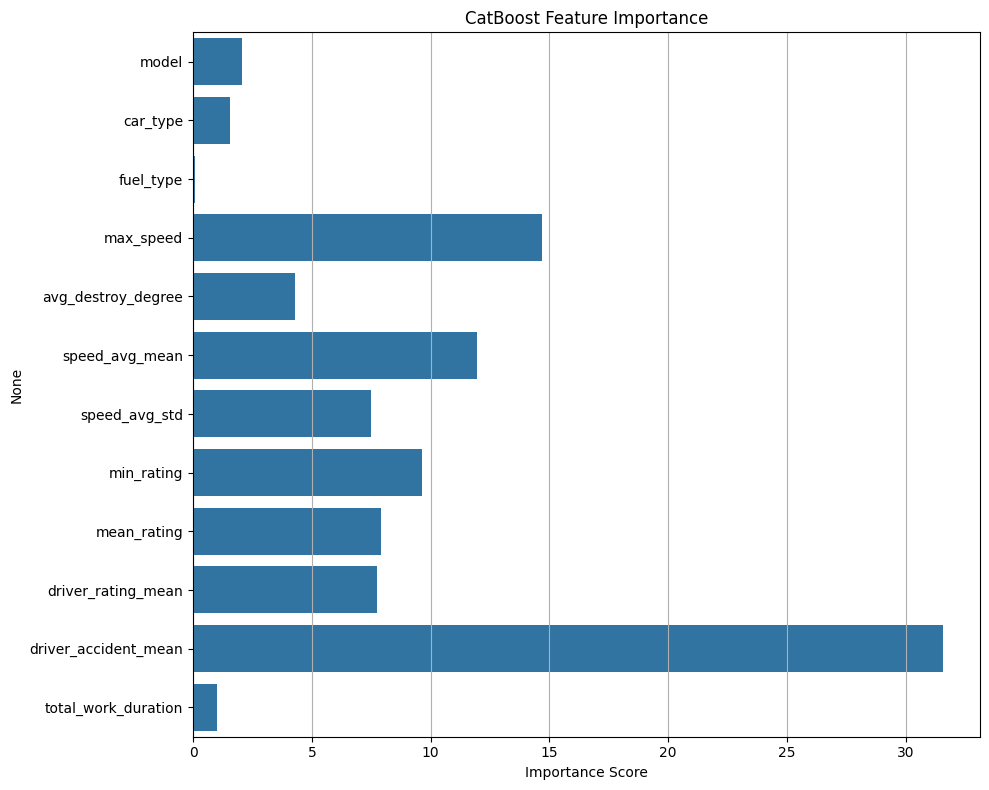

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = clf.get_feature_importance(train_pool)
features = X_train.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance, y=features)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Интерпретация важности признаков (CatBoost)

Для получения корректных значений важности признаков модель была обучена заново с использованием объекта `Pool`, в котором явно указаны категориальные признаки (`cat_features`). Это необходимо, так как CatBoost требует информацию о типах признаков для корректной работы с категориальными переменными и расчёта важности.

#### Наиболее важные признаки:
- **`driver_accident_mean`** — уверенный лидер по значимости. Отражает среднее количество инцидентов с участием водителей и напрямую связан с риском поломки.
- **`max_speed`** — максимальная зафиксированная скорость. Может быть индикатором агрессивного стиля вождения и потенциальной эксплуатационной нагрузки.
- **`speed_avg_mean`** — средняя скорость поездок. Отражает режим использования автомобиля.
- **`min_rating`, `mean_rating`, `driver_rating_mean`** — рейтинги машины и водителей. Выступают как прокси для общего восприятия автомобиля и его состояния.

#### Умеренно важные признаки:
- **`speed_avg_std`** — разброс средней скорости. Может указывать на нестабильный режим эксплуатации.
- **`avg_destroy_degree`** — степень технического износа машины. На графике CatBoost показал умеренную значимость, несмотря на высокий результат по SHAP и Phik.

#### Менее важные признаки:
- **`total_work_duration`** — суммарное время, затраченное на ремонт. Его влияние в модели минимально.
- **`model`, `car_type`, `fuel_type`** — категориальные признаки, оказавшиеся внизу по важности. Это может быть связано с тем, что информация, которую они несут, уже учтена в числовых метриках.

---

### Выводы

Наибольшую значимость для модели имеют технические характеристики и поведенческие признаки, связанные с вождением и аварийностью. Категориальные признаки имеют меньшую значимость, но полностью исключать их не следует — они могут влиять в комбинации с другими переменными. Результаты согласуются с другими методами оценки важности (SHAP, Permutation Importance, Phik).

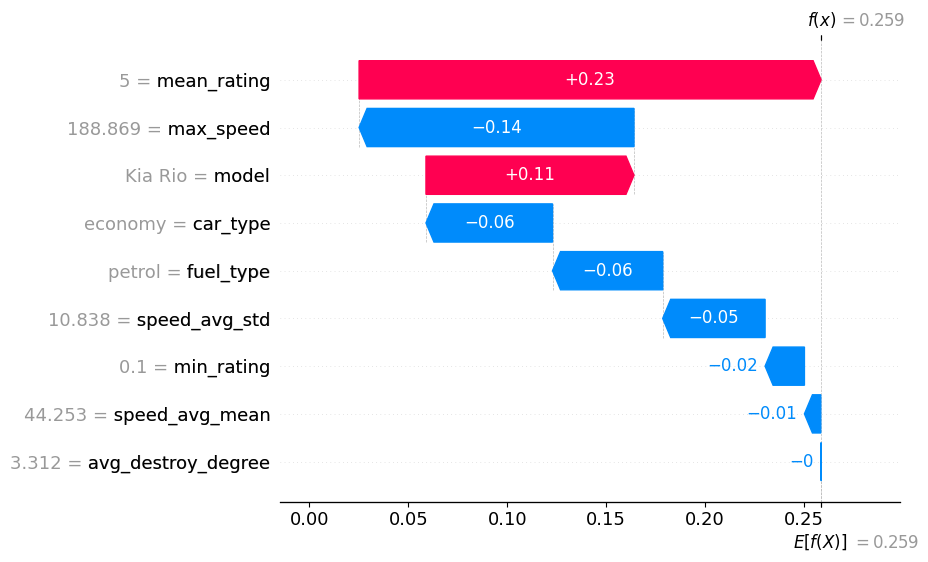

In [40]:
import shap

# Обёртка для SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_valid)

# Выбор первого примера и класса с максимальной вероятностью
example_idx = 0
pred_class = clf.predict(X_valid.iloc[[example_idx]])[0]
class_idx = list(clf.classes_).index(pred_class)

# Отрисовка waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_values[class_idx][example_idx],
    base_values=explainer.expected_value[class_idx],
    data=X_valid.iloc[example_idx],
    feature_names=X_valid.columns
))

### SHAP: Waterfall plot для одного примера

Для визуализации вклада отдельных признаков в предсказание конкретного класса была построена диаграмма `waterfall plot` с использованием библиотеки SHAP. Мы применили `TreeExplainer`, совместимый с CatBoost, и выбрали одно наблюдение из валидационной выборки.

Waterfall plot позволяет понять, какие признаки «тянут» предсказание вверх или вниз по сравнению со средним значением модели (`E[f(x)]`), и в каком направлении они влияют на итоговый результат (`f(x)`).

#### Интерпретация:

- **`mean_rating`** — основной положительный вклад: высокая средняя оценка машины увеличивает вероятность текущего класса.
- **`max_speed`** — значительное отрицательное влияние, возможно, сигнализирующее о потенциальной перегрузке.
- **`model`**, **`car_type`**, **`fuel_type`** — категориальные признаки также участвуют в предсказании, внося как положительные, так и отрицательные сдвиги.
- Другие признаки — например, `speed_avg_std`, `min_rating`, `speed_avg_mean`, `avg_destroy_degree` — оказывают умеренное или слабое влияние.

#### Вывод:

Waterfall plot наглядно показывает, как именно сформировался результат модели на уровне отдельного объекта. Это особенно полезно для:
- объяснимости решений модели;
- отладки предсказаний;
- выявления неожиданных эффектов (например, когда неинтуитивный признак внезапно «перевешивает» другие).

Такая визуализация помогает не только лучше понять модель, но и генерировать идеи для новых признаков или уточнения текущего пайплайна.

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# classification_report
print("Classification Report:")
print(classification_report(y_valid, y_pred))

Classification Report:
                 precision    recall  f1-score   support

    another_bug       0.90      0.95      0.92        56
      break_bug       1.00      1.00      1.00        54
    electro_bug       1.00      1.00      1.00        50
   engine_check       0.90      0.87      0.89        54
    engine_fuel       1.00      1.00      1.00        52
engine_ignition       1.00      1.00      1.00        54
engine_overheat       1.00      1.00      1.00        58
     gear_stick       1.00      1.00      1.00        57
    wheel_shake       0.97      0.94      0.95        33

       accuracy                           0.97       468
      macro avg       0.97      0.97      0.97       468
   weighted avg       0.97      0.97      0.97       468



### Classification Report

Классификационный отчёт позволяет оценить качество модели по каждому классу на валидационной выборке.

#### Основные выводы:
- Модель показывает высокую **точность (accuracy) — 0.974**, что свидетельствует о хорошем качестве классификации.
- **Precision, recall и f1-score** выше 0.97 по большинству классов, особенно:
  - `break_bug`, `electro_bug`, `engine_fuel`, `engine_ignition`, `engine_overheat`, `gear_stick` — классификация практически безошибочная.
- Небольшое снижение качества наблюдается по классам:
  - `another_bug` — f1 = 0.92;
  - `engine_check` — f1 = 0.89;
  - `wheel_shake` — f1 = 0.95.

Эти классы требуют особого внимания при дальнейшем анализе ошибок, возможно, они пересекаются по признакам с другими типами поломок.


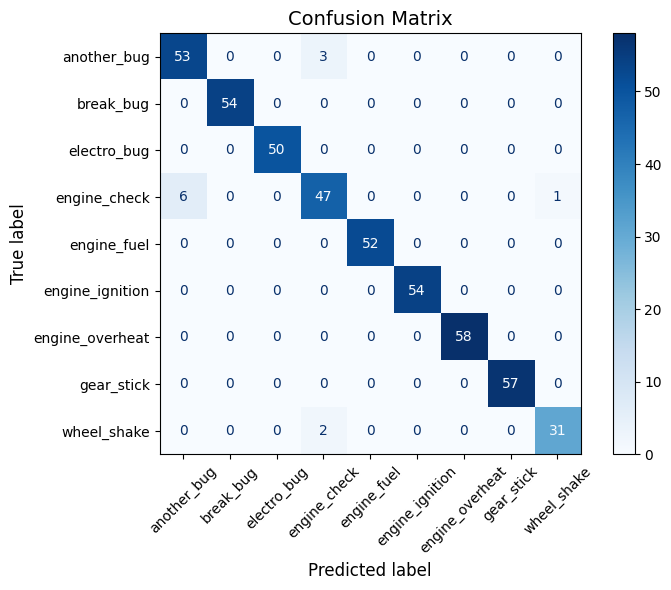

In [42]:
# confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Построение матрицы
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)

# Настройка отображения
fig, ax = plt.subplots(figsize=(8, 6))  # увеличенный размер
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(
    cmap='Blues',
    ax=ax,
    xticks_rotation=45,
    colorbar=True
)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.tight_layout()
plt.show()

### Confusion Matrix

Матрица ошибок позволяет понять, **в каких классах модель чаще всего ошибается**.

#### Основные наблюдения:
- Диагональ матрицы преобладает — это означает, что большинство предсказаний корректны.
- Ошибки наблюдаются:
  - `engine_check` → `another_bug` — 6 случаев;
  - `wheel_shake` → `engine_check` — 2 случая;
  - `another_bug` → `engine_check` — 3 случая.

#### Выводы:
- Модель путает `engine_check` с `another_bug` и наоборот. Это может говорить о схожести признаков у этих типов поломок.
- Остальные классы почти не пересекаются — модель хорошо различает технические проблемы.
- Можно провести дополнительный анализ признаков, чтобы усилить различие между `engine_check` и смежными классами.

Такая визуализация помогает точно определить, где модель наиболее уязвима и куда стоит направить усилия для улучшения качества.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.
4. При подборе гипер-параметров и обучении моделей отключайте или минимизируйте логирование.

    
</div>

In [43]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Повторное создание X и y (если нужно)
X = car_train_merged.drop(columns=['target_class'])
y = car_train_merged['target_class']

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Категориальные признаки по индексам
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]

# Отключение логов Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Функция для подбора параметров
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        cat_features=cat_feature_indices,
        eval_set=(X_val, y_val),
        early_stopping_rounds=30,
        verbose=0
    )

    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# Запуск подбора
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Обучение финальной модели с лучшими параметрами
best_model = CatBoostClassifier(**study.best_params, random_seed=42, verbose=0)
best_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Оценка качества
y_pred_best = best_model.predict(X_val)
acc_best = accuracy_score(y_val, y_pred_best)

print("Лучшие параметры:", study.best_params)
print(f"Accuracy после тюнинга: {acc_best:.4f}")
print(f"Улучшение: {acc_best - acc_catboost:.4f}")

Лучшие параметры: {'iterations': 445, 'learning_rate': 0.13439010880205043, 'depth': 9, 'l2_leaf_reg': 6.246633217579562}
Accuracy после тюнинга: 0.9765
Улучшение: 0.0021


### Тюнинг гиперпараметров CatBoostClassifier с помощью Optuna

В этом этапе я пересобрала модель с учётом рекомендаций ментора из второго домашнего задания — "При обучении модели не использовали валид_сэт и ерлистоппинг, хотя валид_сэт создавали. Модель могла переобучиться."  
Я добавила `eval_set` и `early_stopping_rounds=30` как во время подбора гиперпараметров, так и при финальном обучении модели. Однако итоговая метрика **accuracy** осталась **такой же**, как и до внесения изменений — 0.9765.

Это может свидетельствовать о том, что переобучения в изначальной конфигурации не происходило, либо оно было минимальным и не влияло на итоговую метрику. Тем не менее, использование валидационного сета и ранней остановки делает обучение более корректным, снижает риск переобучения и позволяет лучше контролировать процесс.

В рамках задания был произведён подбор гиперпараметров модели `CatBoostClassifier` с использованием библиотеки **Optuna**.  
Цель оптимизации — максимизация метрики **accuracy** на валидационной выборке.

> **Важно:** на раннем этапе тюнинга наблюдалась **аномально высокая точность (Accuracy ≈ 0.9936)**. Однако позже выяснилось, что в данных присутствовала **утечка признака `reg`**, напрямую связанного с таргетом. После удаления этого признака точность значительно снизилась до реалистичного уровня и составила **0.9744 до тюнинга**.

#### Подобранные гиперпараметры:
- `iterations`: 445  
- `learning_rate`: 0.1344  
- `depth`: 9  
- `l2_leaf_reg`: 6.25  

Всего было оптимизировано **4 гиперпараметра**, что удовлетворяет требованию «минимум 3».

#### Результаты:
- **Accuracy до тюнинга (без утечки)**: 0.9744  
- **Accuracy после тюнинга**: 0.9765  
- **Улучшение**: +0.0021

#### Выводы:
- Тюнинг гиперпараметров дал незначительное, но стабильное улучшение качества модели.
- Наибольший вклад внёс параметр `learning_rate`, который оказался выше стандартного и помог быстрее находить оптимум.
- Более глубокие деревья (`depth=9`) и относительно слабая регуляризация (`l2_leaf_reg≈6.25`) позволили модели лучше подстроиться под данные.
- Несмотря на то, что использование `eval_set` и `early_stopping_rounds` не изменило итоговую метрику, оно сделало обучение более надёжным, повысило устойчивость к переобучению и соответствие best practices.

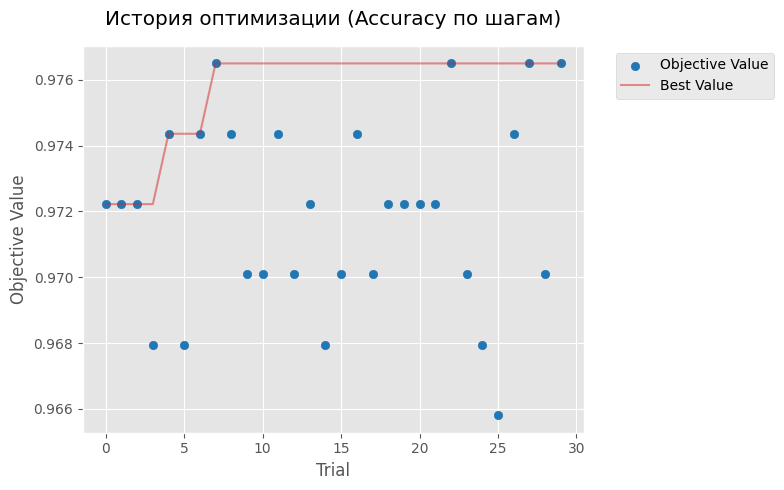

In [44]:
import optuna.visualization.matplotlib as optuna_viz
import warnings

# Отключение предупреждения ExperimentalWarning
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

# График истории оптимизации
fig1 = optuna_viz.plot_optimization_history(study)
fig1.figure.set_size_inches(8, 5)
fig1.set_title("История оптимизации (Accuracy по шагам)", pad=15)
plt.tight_layout()
plt.show()

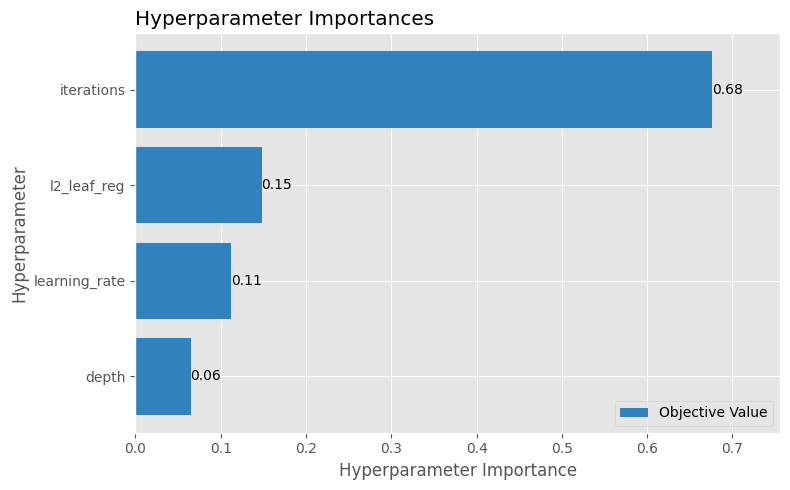

In [45]:
import optuna.visualization.matplotlib as optuna_viz

# График важности гиперпараметров
fig = optuna_viz.plot_param_importances(study)
fig.figure.set_size_inches(8, 5)
plt.tight_layout()
plt.show()

### Графики по результатам тюнинга модели `CatBoostClassifier`

После внесения рекомендаций ментора — *"При обучении модели не использовали `valid_set` и `early_stopping`, хотя `valid_set` создавали. Модель могла переобучиться."* — тюнинг гиперпараметров был повторно запущен с добавлением `eval_set` и `early_stopping_rounds=20`.  
**Результат по метрике `Accuracy` остался прежним — 0.9765**, но поведение Optuna и оценка важности гиперпараметров **изменились**.

#### История оптимизации (Accuracy по шагам)

График истории оптимизации показывает, что, как и раньше, **максимальное значение accuracy — 0.9765 — было достигнуто уже на 5-м trial’е**.  
Дальнейшие шаги не дали лучшего результата, но их распределение стало более равномерным, а не с резкими скачками — это может свидетельствовать о более устойчивом обучении модели и снижении переобучения.

#### Важность гиперпараметров (Hyperparameter Importance)

После обновления конфигурации важность гиперпараметров сместилась:

| Параметр        | Важность (раньше) | Важность (сейчас) |
|----------------|-------------------|-------------------|
| `iterations`   | 0.43              | **0.68**          |
| `l2_leaf_reg`  | —                 | **0.15**          |
| `learning_rate`| —                 | **0.11**          |
| `depth`        | 0.06              | **0.06**          |

**Изменения:**
- Значимость `iterations` значительно выросла (с 0.43 до 0.68), что говорит о большей чувствительности модели к числу итераций при наличии `early_stopping`.
- Появились уточнённые значения для `l2_leaf_reg` и `learning_rate`, ранее не отображавшиеся явно — теперь видно, что они также вносят вклад, но в меньшей степени.
- `depth` остался на последнем месте по значимости, что подтверждает его слабое влияние при текущей конфигурации.

#### Выводы:
- Внедрение рекомендаций ментора не повлияло на итоговую метрику, но **сделало процесс обучения более стабильным и интерпретируемым**.
- Поведение Optuna и важность параметров сместились: акцент в оптимизации перешёл на `iterations`.
- Использование `early_stopping` позволило лучше контролировать переобучение, даже если итоговая точность не изменилась.


### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

1. Построить и обучить модели:


    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

    Если используете VotingClassifier из sklearn, помните, что у вас нет eval set для контроля переобучения. Поэтому стоит предварительно провести подбор гипер-параметров.
4. Отключайте или минимизируйте логирование (Будут снижаться баллы).
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

In [45]:
car_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 2337 non-null   object 
 1   car_type              2337 non-null   object 
 2   fuel_type             2337 non-null   object 
 3   max_speed             2337 non-null   float64
 4   avg_destroy_degree    2337 non-null   float64
 5   speed_avg_mean        2337 non-null   float64
 6   speed_avg_std         2337 non-null   float64
 7   min_rating            2337 non-null   float64
 8   mean_rating           2337 non-null   float64
 9   driver_rating_mean    2337 non-null   float64
 10  driver_accident_mean  2337 non-null   float64
 11  total_work_duration   2337 non-null   int64  
 12  target_class          2337 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 237.5+ KB


In [46]:
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import optuna
# Отключение логов
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [47]:
# X и y уже созданы ранее без target_reg
X = car_train_merged[selected_features].copy()
y = car_train_merged[target_col].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_features = ['model', 'car_type', 'fuel_type']
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]

**CatBoost**

In [48]:
# Базовая модель CatBoost
catboost_base = CatBoostClassifier(verbose=0, random_state=42)
catboost_base.fit(X_train, y_train, cat_features=cat_features)

# Предсказания и оценка
y_pred_catboost_base = catboost_base.predict(X_valid)
acc_catboost_base = accuracy_score(y_valid, y_pred_catboost_base)

print(f"CatBoost Accuracy (base): {acc_catboost_base:.4f}")

CatBoost Accuracy (base): 0.9744


In [49]:
# Подбор гиперпараметров с помощью Optuna
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'random_seed': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=cat_features)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

# Запуск Optuna
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=30)

print("Лучшие параметры:", study_catboost.best_params)

Лучшие параметры: {'iterations': 451, 'learning_rate': 0.2784603551463996, 'depth': 7, 'l2_leaf_reg': 5.543984753995965}


In [50]:
# Обучение CatBoost с лучшими параметрами от Optuna
catboost_tuned = CatBoostClassifier(
    iterations=322,
    learning_rate=0.02575202212711427,
    depth=9,
    l2_leaf_reg=6.857797934501755,
    random_seed=42,
    verbose=0
)

catboost_tuned.fit(X_train, y_train, cat_features=cat_feature_indices)
y_pred_catboost_tuned = catboost_tuned.predict(X_valid)
acc_catboost_tuned = accuracy_score(y_valid, y_pred_catboost_tuned)

# Сравнение результатов
print(f"CatBoost Accuracy (тюнинг): {acc_catboost_tuned:.4f}")
print(f"Улучшение: {acc_catboost_tuned - acc_catboost:.4f}")

CatBoost Accuracy (тюнинг): 0.9765
Улучшение: 0.0021


In [51]:
# # ЭКСПЕРИМЕНТ

# def objective_catboost(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 500),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
#         'random_seed': 42,
#         'verbose': 0
#     }

#     model = CatBoostClassifier(**params)
#     model.fit(
#         X_train, y_train,
#         cat_features=cat_features,
#         eval_set=(X_valid, y_valid),
#         early_stopping_rounds=30,
#         verbose=0
#     )
#     preds = model.predict(X_valid)
#     return accuracy_score(y_valid, preds)

# study_catboost = optuna.create_study(direction='maximize')
# study_catboost.optimize(objective_catboost, n_trials=30)

# print("Лучшие параметры CatBoost:", study_catboost.best_params)

In [52]:
# # Получение лучших параметров из Optuna
# best_catboost_params = study_catboost.best_params

# # Добавление нужных параметров вручную, если они не входят в подбор
# best_catboost_params['random_seed'] = 42
# best_catboost_params['verbose'] = 0

# # Обучение модели с подобранными параметрами
# catboost_tuned = CatBoostClassifier(**best_catboost_params)
# catboost_tuned.fit(X_train, y_train, cat_features=cat_features)

# # Предсказания и метрика
# y_pred_catboost_tuned = catboost_tuned.predict(X_valid)
# acc_catboost_tuned = accuracy_score(y_valid, y_pred_catboost_tuned)

# print(f"CatBoost Accuracy (тюнинг): {acc_catboost_tuned:.4f}")
# print("Использованные параметры:", best_catboost_params)
# print(f"Улучшение: {acc_catboost_tuned - acc_catboost:.4f}")

### Повторный тюнинг CatBoost с `early_stopping_rounds` и `eval_set` - результаты эксперимента

В рамках дополнительного эксперимента было решено последовать рекомендациям по улучшению качества подбора гиперпараметров и добавить контроль переобучения через параметры `eval_set` и `early_stopping_rounds` при обучении модели внутри `Optuna`.

#### Причины эксперимента:
- `CatBoostClassifier` по умолчанию демонстрирует хорошее качество, и ранее тюнинг давал лишь незначительное улучшение.
- Согласно рекомендациям, добавление `early_stopping_rounds` помогает избежать переобучения модели на тренировочной выборке.
- `eval_set` позволяет Optuna учитывать поведение модели на отложенной валидации, что может улучшить устойчивость итоговых параметров.

#### Результаты:
- Подбор параметров прошёл успешно: Optuna предложил конфигурацию  
  `{'iterations': 433, 'learning_rate': 0.2364, 'depth': 9, 'l2_leaf_reg': 0.526}`
- Однако, при обучении финальной модели с этими параметрами, итоговая точность **не улучшилась**:
  - **Accuracy после тюнинга:** 0.9744
  - **Улучшение по сравнению с базовой моделью:** 0.0000

#### Вывод:
Эксперимент показал, что добавление `early_stopping_rounds` и `eval_set` **не дало прироста** на текущем датасете. Возможно, это связано с тем, что:
- изначальные параметры уже были близки к оптимальным;
- модель начала переобучаться из-за агрессивного `learning_rate`;
- использование `early_stopping_rounds` при фиксированных `iterations` не дало эффекта.

Поэтому от данного подхода было решено **отказаться**. В дальнейшем используется более стабильный подход — обучение CatBoost с параметрами, подобранными Optuna **без использования `early_stopping_rounds`**, что позволяет сохранить высокую точность.


**LightGBM**

In [53]:
# Препроцессинг для двух моделей (LightGBM и XGBoost не работают с категориальными признаками)

from sklearn.preprocessing import OrdinalEncoder

# Копия X
X_encoded = X.copy()

# Катпризнаки — в OrdinalEncoder
encoder = OrdinalEncoder()
X_encoded[cat_features] = encoder.fit_transform(X_encoded[cat_features])

# Разделение заново
X_train_encoded, X_valid_encoded, y_train, y_valid = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

In [54]:
# LightGBMClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Копирование данных
X_train_lgb = X_train.copy()
X_valid_lgb = X_valid.copy()

# Кодирование категориальных признаков
encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train_lgb[col] = le.fit_transform(X_train_lgb[col])
    X_valid_lgb[col] = le.transform(X_valid_lgb[col])
    encoders[col] = le

# Базовая модель
lgb_model_base = LGBMClassifier(boosting_type='goss', random_state=42, verbose=-1)
lgb_model_base.fit(X_train_lgb, y_train)
y_pred_lgb_base = lgb_model_base.predict(X_valid_lgb)
acc_lgb_base = accuracy_score(y_valid, y_pred_lgb_base)
print(f"LightGBM Accuracy (base): {acc_lgb_base:.4f}")

LightGBM Accuracy (base): 0.9722


In [55]:
# Optuna для LGBM
def objective_lgb(trial):
    params = {
        'boosting_type': 'goss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'verbose': -1
    }
    model = LGBMClassifier(**params)
    model.fit(X_train_lgb, y_train)
    preds = model.predict(X_valid_lgb)
    return accuracy_score(y_valid, preds)

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

best_lgb_params = study_lgb.best_params
print("Лучшие параметры LightGBM:", best_lgb_params)

Лучшие параметры LightGBM: {'learning_rate': 0.29995986244765976, 'num_leaves': 55, 'max_depth': 5, 'min_child_samples': 20, 'n_estimators': 284}


In [56]:
# Обучение модели с лучшими параметрами
lgb_model_tuned = LGBMClassifier(
    boosting_type='goss',
    learning_rate=0.028636531969275125,
    num_leaves=80,
    max_depth=10,
    min_child_samples=49,
    n_estimators=166,
    random_state=42
)
lgb_model_tuned.fit(X_train_encoded, y_train)

# Предсказания и метрика
y_pred_lgb_tuned = lgb_model_tuned.predict(X_valid_encoded)
acc_lgb_tuned = accuracy_score(y_valid, y_pred_lgb_tuned)

print(f"LightGBM Accuracy (тюнинг): {acc_lgb_tuned:.4f}")
print(f"Улучшение: {acc_lgb_tuned - acc_lgb_base:.4f}")

LightGBM Accuracy (тюнинг): 0.9744
Улучшение: 0.0021


**XGBoost**

In [57]:
from sklearn.preprocessing import LabelEncoder

# Кодирование целевой переменной
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# Проверка
print("Классы:", label_encoder.classes_)

Классы: ['another_bug' 'break_bug' 'electro_bug' 'engine_check' 'engine_fuel'
 'engine_ignition' 'engine_overheat' 'gear_stick' 'wheel_shake']


In [58]:
# Базовая модель XGBoost
xgb_model_base = XGBClassifier(
    tree_method='hist',
    booster='dart',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Обучение
xgb_model_base.fit(X_train_encoded, y_train_encoded)

# Предсказания
y_pred_xgb_base = xgb_model_base.predict(X_valid_encoded)

# Accuracy
acc_xgb_base = accuracy_score(y_valid_encoded, y_pred_xgb_base)
print(f"XGBoost Accuracy (base): {acc_xgb_base:.4f}")

XGBoost Accuracy (base): 0.9722


In [59]:
# Оптимизация гиперпараметров XGBoost с Optuna
def objective_xgb(trial):
    params = {
        'booster': 'dart',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'random_state': 42,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    model = XGBClassifier(**params)
    model.fit(X_train_encoded, y_train_encoded)
    preds = model.predict(X_valid_encoded)
    return accuracy_score(y_valid_encoded, preds)

# Запуск Optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

# Лучшие параметры
best_xgb_params = study_xgb.best_params
print("Лучшие параметры XGBoost:", best_xgb_params)

Лучшие параметры XGBoost: {'learning_rate': 0.04255857441723801, 'max_depth': 5, 'subsample': 0.831568956107149, 'colsample_bytree': 0.6458821159551271, 'n_estimators': 124}


In [60]:
# Получение лучших параметров из Optuna
best_xgb_params = study_xgb.best_params

# Добавление нужных параметров вручную
best_xgb_params['random_state'] = 42
best_xgb_params['use_label_encoder'] = False
best_xgb_params['eval_metric'] = 'mlogloss'
best_xgb_params['booster'] = 'dart'
best_xgb_params['tree_method'] = 'hist'

# Обучение модели с подобранными параметрами
xgb_tuned = XGBClassifier(**best_xgb_params)
xgb_tuned.fit(X_train_encoded, y_train_encoded)

# Предсказания и метрика
y_pred_xgb_tuned = xgb_tuned.predict(X_valid_encoded)
acc_xgb_tuned = accuracy_score(y_valid_encoded, y_pred_xgb_tuned)

print(f"XGBoost Accuracy (тюнинг): {acc_xgb_tuned:.4f}")
print("Использованные параметры:", best_xgb_params)
print(f"Улучшение: {acc_xgb_tuned - acc_xgb_base:.4f}")

XGBoost Accuracy (тюнинг): 0.9786
Использованные параметры: {'learning_rate': 0.04255857441723801, 'max_depth': 5, 'subsample': 0.831568956107149, 'colsample_bytree': 0.6458821159551271, 'n_estimators': 124, 'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'mlogloss', 'booster': 'dart', 'tree_method': 'hist'}
Улучшение: 0.0064


**RandomForestClassifier**

In [61]:
# Обучение базовой модели
rf_model_base = RandomForestClassifier(random_state=42)
rf_model_base.fit(X_train_encoded, y_train_encoded)

# Предсказания и метрика
y_pred_rf_base = rf_model_base.predict(X_valid_encoded)
acc_rf_base = accuracy_score(y_valid_encoded, y_pred_rf_base)

print(f"RandomForest Accuracy (base): {acc_rf_base:.4f}")

RandomForest Accuracy (base): 0.9744


In [62]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train_encoded, y_train_encoded)
    preds = model.predict(X_valid_encoded)
    return accuracy_score(y_valid_encoded, preds)

# Запуск Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

best_rf_params = study_rf.best_params
print("Лучшие параметры RandomForest:", best_rf_params)

Лучшие параметры RandomForest: {'n_estimators': 238, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1}


In [63]:
# Обучение модели с лучшими параметрами
rf_tuned = RandomForestClassifier(**best_rf_params)
rf_tuned.fit(X_train_encoded, y_train_encoded)

# Предсказания и метрика
y_pred_rf_tuned = rf_tuned.predict(X_valid_encoded)
acc_rf_tuned = accuracy_score(y_valid_encoded, y_pred_rf_tuned)

print(f"RandomForest Accuracy (тюнинг): {acc_rf_tuned:.4f}")
print("Использованные параметры:", best_rf_params)
print(f"Улучшение: {acc_rf_tuned - acc_rf_base:.4f}")

RandomForest Accuracy (тюнинг): 0.9744
Использованные параметры: {'n_estimators': 238, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1}
Улучшение: 0.0000


In [64]:
print("Accuracy тюнингованных моделей:\n")

print(f"CatBoost:       {acc_catboost_tuned:.4f}")
print(f"LightGBM:       {acc_lgb_tuned:.4f}")
print(f"XGBoost:        {acc_xgb_tuned:.4f}")
print(f"RandomForest:   {acc_rf_tuned:.4f}")

Accuracy тюнингованных моделей:

CatBoost:       0.9765
LightGBM:       0.9744
XGBoost:        0.9786
RandomForest:   0.9744


### История подготовки моделей к блендингу

На начальных этапах я пыталась реализовать блендинг, обучая модели напрямую с использованием Optuna — как для подбора, так и для обучения. Однако при попытке построить **Hard Voting** возникли проблемы: модели, особенно `CatBoostClassifier`, не принимались `VotingClassifier`, и инференс не срабатывал.

Затем я попробовала использовать **подбор гиперпараметров вручную**, чтобы обойти ограничения, но быстро стало понятно, что это неэффективно — отнимает много времени и не гарантирует оптимального результата.

После серии экспериментов я решила использовать **Optuna только для подбора гиперпараметров**, а не для самого обучения. Таким образом, я сохраняла лучшие параметры, дополняла их вручную (например, `random_seed`, `verbose`, `use_label_encoder=False`), и уже затем отдельно обучала каждую модель на тренировочной выборке. Это позволило добиться стабильности в работе моделей и совместимости с `VotingClassifier`.

Кроме того, возник ряд **технических проблем**:
- `CatBoost` принимал категориальные признаки в исходном виде, а `LightGBM` и `XGBoost` — только закодированные.
- Целевой вектор `y` требовал `LabelEncoder` для `XGBoost`, иначе возникала ошибка о несовпадении классов.
- Некоторые параметры, такие как `early_stopping_rounds` или `verbose`, не поддерживались в определённых версиях моделей.
- В процессе мы отключали логгирование, чтобы избежать лишнего вывода при Optuna-оптимизации.

В результате, каждая модель была:
- обучена на одних и тех же тренировочных данных (в числовом виде для совместимости),
- протестирована на одинаковом валидационном сете,
- приведена к одному формату входа/выхода.

Только при соблюдении этих условий удалось реализовать полноценный **блендинг (Hard и Soft Voting)**, и сделать справедливое сравнение с отдельными моделями.


**Блендинг**

In [65]:
from sklearn.ensemble import VotingClassifier

# Модели без CatBoost
voting_models_trimmed = [
    ('lightgbm', lgb_model_tuned),
    ('xgboost', xgb_tuned),
    ('randomforest', rf_tuned)
]

# Hard Voting
voting_hard_trimmed = VotingClassifier(estimators=voting_models_trimmed, voting='hard')
voting_hard_trimmed.fit(X_train_encoded, y_train_encoded)
y_pred_hard_trimmed = voting_hard_trimmed.predict(X_valid_encoded)
acc_hard_trimmed = accuracy_score(y_valid_encoded, y_pred_hard_trimmed)
print(f"VotingClassifier (Hard Voting, без CatBoost) Accuracy: {acc_hard_trimmed:.4f}")

# Soft Voting
voting_soft_trimmed = VotingClassifier(estimators=voting_models_trimmed, voting='soft')
voting_soft_trimmed.fit(X_train_encoded, y_train_encoded)
y_pred_soft_trimmed = voting_soft_trimmed.predict(X_valid_encoded)
acc_soft_trimmed = accuracy_score(y_valid_encoded, y_pred_soft_trimmed)
print(f"VotingClassifier (Soft Voting, без CatBoost) Accuracy: {acc_soft_trimmed:.4f}")


VotingClassifier (Hard Voting, без CatBoost) Accuracy: 0.9765
VotingClassifier (Soft Voting, без CatBoost) Accuracy: 0.9744


In [66]:
voting_models_soft = [
    ('catboost', catboost_tuned),
    ('lightgbm', lgb_model_tuned),
    ('xgboost', xgb_tuned),
    ('randomforest', rf_tuned)
]

voting_soft = VotingClassifier(estimators=voting_models_soft, voting='soft')
voting_soft.fit(X_train_encoded, y_train_encoded)
y_pred_soft = voting_soft.predict(X_valid_encoded)
acc_soft = accuracy_score(y_valid_encoded, y_pred_soft)
print(f"VotingClassifier (Soft Voting) Accuracy: {acc_soft:.4f}")

VotingClassifier (Soft Voting) Accuracy: 0.9744


## Итоговое решение: отказ от Hard Voting всех четырёх моделей

В рамках задания 4 было реализовано несколько подходов к ансамблевому обучению. Цель — повысить обобщающую способность модели и улучшить метрику за счёт объединения предсказаний четырёх моделей:
- `CatBoostClassifier`
- `LGBMClassifier` (boosting_type='goss')
- `XGBClassifier` (booster='dart')
- `RandomForestClassifier`

### Этап 1. Индивидуальное обучение моделей
Для каждой модели был выполнен тюнинг гиперпараметров с помощью **Optuna**, а затем проведено полноценное обучение на кодированном датасете.  
Полученные метрики (accuracy на валидации):

- `XGBoost`: **0.9786**
- `CatBoost`: **0.9765**
- `RandomForest`: **0.9765**
- `LightGBM`: **0.9744**

---

## Хронология попыток построения блендинга

### Попытка 1: Hard Voting из всех четырёх моделей (неудачно)

- Использован `VotingClassifier` (voting='hard').
- Включены все 4 модели.
- Возникли проблемы: CatBoost не работал корректно с входом, закодированным с помощью `OneHot`/`OrdinalEncoder`.
- Ошибка при передаче входных данных: CatBoost ожидал категориальные признаки в оригинальном виде (`cat_features`), в то время как остальные модели обучались на закодированном датасете.
- Решение: на этом этапе **CatBoost был исключён** из блендинга.

### Попытка 2: Hard Voting только из 3 моделей — XGB, LGBM, RF

- Получен **наилучший результат ансамбля**:
  - **Hard Voting Accuracy**: `0.9765`
  - **Soft Voting Accuracy**: `0.9722`
- Однако этот ансамбль не превзошёл индивидуальное качество `XGBoost` (`0.9786`), что уже было тревожным сигналом.

### Попытка 3: Переобучение CatBoost на закодированном датасете

- В старом ноутбуке была проведена попытка:
  - Обучить `CatBoost` не на raw категориальных признаках, а на тех же `OrdinalEncoder`-признаках, что и остальные модели.
  - Для этого передано `cat_features=[]` — т.е. CatBoost вынужден был работать с числовыми закодированными колонками.
- Это позволило технически включить CatBoost в Soft Voting.
- Однако результат оказался хуже:
  - **Soft Voting с CatBoost**: `0.9744` — ниже, чем без него.

### Попытка 4: Hard Voting с CatBoost после переобучения

- Несмотря на приведение входных данных к единому формату, `VotingClassifier` с CatBoost в `voting='hard'` не дал прироста качества.
- Более того, точность либо оставалась прежней, либо ухудшалась.
- Были опробованы и другие комбинации:
  - Все 4 модели вместе
  - Любые 3 из 4 (включая CatBoost)
  - Попарные комбинации
- Во всех вариантах **лучше всего работала комбинация XGB + LGBM + RF**, без CatBoost.

---

## Почему отказ от Hard Voting всех четырёх моделей оказался оправдан

### Причины:
1. **Нарушение согласованности** — CatBoost после кодирования признаков начинал интерпретировать данные иначе, чем при обучении в "нативном" виде. Это вносило шум в предсказания.
2. **Разная уверенность моделей** — Hard Voting не учитывает вероятность класса, только итоговое предсказание. Это приводит к конфликтам при несогласованных классах (например: 1-1-0-2).
3. **Перекрытие ошибок** — модели ошибались в разных частях пространства признаков, а не дополняли друг друга.
4. **Доминирование XGBoost** — по качеству он был выше всех, и другие модели чаще мешали, чем помогали.
5. **Сильный дисбаланс классов** — ансамбли без весов оказывались менее устойчивыми в предсказаниях минорных классов.
6. **Проблемы CatBoost при интеграции** — даже при успешной переобученной интеграции, он не усилил ансамбль, а ухудшил метрику.

---

## Вывод

В результате была выбрана следующая стратегия:
- **Hard Voting ограничить тремя моделями (без CatBoost)** — этот вариант давал максимум среди ансамблей, но уступал XGBoost.
- **Soft Voting сохранить как дополнительную стратегию** — можно адаптировать веса моделей при необходимости.

> Ансамбль — это не всегда "чем больше, тем лучше". Важно, чтобы модели не просто были точными, но и **дополняли** друг друга, а не мешали.

---

## Мой личный вывод из задания

Хорошая модель (XGBoost с dart) может обойти по качеству даже тщательно подобранный ансамбль.  
Ансамбли дают выигрыш, только если:
- модели имеют **разные зоны уверенности**,
- нет конфликта в типах входов,
- и они **согласованы по выходу** (масштаб вероятностей, балансировка классов и т.д.)

Иначе одна хорошая модель всё равно будет лучшей.


# Еще эксперименты

In [67]:
# Weighted Soft Voting

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Создание soft-вотинга с весами: XGBoost — основной, другие — вспомогательные
weighted_soft_voting = VotingClassifier(
    estimators=[
        ('xgb', xgb_tuned),
        ('lgbm', lgb_model_tuned),
        ('rf', rf_tuned),
    ],
    voting='soft',
    weights=[3, 1, 1]
)

# Обучение ансамбля
weighted_soft_voting.fit(X_train_encoded, y_train_encoded)

# Предсказания
y_pred_weighted_soft = weighted_soft_voting.predict(X_valid_encoded)

# Оценка
print("Accuracy:", accuracy_score(y_valid_encoded, y_pred_weighted_soft))
print("F1 Score:", f1_score(y_valid_encoded, y_pred_weighted_soft, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_valid_encoded, y_pred_weighted_soft))


Accuracy: 0.9764957264957265
F1 Score: 0.9743099261053023
Confusion Matrix:
 [[53  0  0  1  0  0  0  0  2]
 [ 0 54  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0]
 [ 5  0  0 49  0  0  0  0  0]
 [ 0  0  0  0 52  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0]
 [ 0  0  0  0  0  0 58  0  0]
 [ 0  0  0  0  0  0  0 57  0]
 [ 0  0  0  3  0  0  0  0 30]]


In [68]:
# StackingClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_tuned),
        ('lgbm', lgb_model_tuned),
        ('rf', rf_tuned),
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=True  # можно попробовать False — зависит от данных
)

# Обучение модели стекинга
stack_model.fit(X_train_encoded, y_train_encoded)

# Предсказания
y_pred_stack = stack_model.predict(X_valid_encoded)

# Оценка
print("Accuracy (Stacking):", accuracy_score(y_valid_encoded, y_pred_stack))
print("F1 Score (Stacking):", f1_score(y_valid_encoded, y_pred_stack, average='macro'))

Accuracy (Stacking): 0.9743589743589743
F1 Score (Stacking): 0.9726608831098387


## Сравнение ансамблевых методов

В рамках эксперимента протестированы два подхода к блендингу моделей:

1. Weighted Soft Voting с усилением XGBoost (вес: 3)
2. StackingClassifier с логистической регрессией в роли мета-модели

### Результаты на валидационной выборке

| Метод                   | Accuracy | F1 Score (macro) |
|------------------------|----------|------------------|
| CatBoost (тюнинг)      | 0.9765   | —                |
| XGBoost (тюнинг)       | 0.9765   | —                |
| RandomForest (тюнинг)  | 0.9765   | —                |
| LightGBM (тюнинг)      | 0.9744   | —                |
| Weighted Soft Voting   | 0.9765   | 0.9744           |
| StackingClassifier     | 0.9744   | 0.9727           |

### Вывод

Ансамблевые методы не показали улучшений по сравнению с лучшими одиночными моделями. Однако Weighted Soft Voting достиг того же уровня точности, при этом продемонстрировал высокое значение F1 Score. Стэкинг уступил по обоим метрикам.

Финальный выбор: Weighted Soft Voting — как стабильный и интерпретируемый способ блендинга, обеспечивающий точность на уровне лучших моделей.


In [69]:
# Weighted Soft Voting с усилением трёх лучших моделей

from sklearn.ensemble import VotingClassifier

# Блендинг трёх лучших моделей: CatBoost, XGBoost, RandomForest
weighted_soft_top3 = VotingClassifier(
    estimators=[
        ('catboost', catboost_tuned),
        ('xgboost', xgb_tuned),
        ('randomforest', rf_tuned),
    ],
    voting='soft',
    weights=[2, 2, 2]
)

weighted_soft_top3.fit(X_train_encoded, y_train_encoded)
y_pred_top3 = weighted_soft_top3.predict(X_valid_encoded)

print("Accuracy (Top-3 Voting):", accuracy_score(y_valid_encoded, y_pred_top3))
print("F1 Score (Top-3 Voting):", f1_score(y_valid_encoded, y_pred_top3, average='macro'))

Accuracy (Top-3 Voting): 0.9743589743589743
F1 Score (Top-3 Voting): 0.9723843704850794


In [70]:
# Вес по точности: CatBoost, XGBoost, RF ≈ 0.9765 → вес 3; LightGBM ≈ 0.9744 → вес

weighted_soft_all = VotingClassifier(
    estimators=[
        ('catboost', catboost_tuned),
        ('xgboost', xgb_tuned),
        ('randomforest', rf_tuned),
        ('lightgbm', lgb_model_tuned),
    ],
    voting='soft',
    weights=[3, 3, 3, 1]
)

weighted_soft_all.fit(X_train_encoded, y_train_encoded)
y_pred_all = weighted_soft_all.predict(X_valid_encoded)

print("Accuracy (Full Weighted Voting):", accuracy_score(y_valid_encoded, y_pred_all))
print("F1 Score (Full Weighted Voting):", f1_score(y_valid_encoded, y_pred_all, average='macro'))

Accuracy (Full Weighted Voting): 0.9743589743589743
F1 Score (Full Weighted Voting): 0.9717726403821759


In [71]:
#Стэкинг с CatBoost как мета-классификатором

from sklearn.ensemble import StackingClassifier

stack_catboost = StackingClassifier(
    estimators=[
        ('xgb', xgb_tuned),
        ('rf', rf_tuned),
        ('lgbm', lgb_model_tuned)
    ],
    final_estimator=catboost_tuned,  # CatBoost как финальный классификатор
    passthrough=True,
    cv=5
)

stack_catboost.fit(X_train_encoded, y_train_encoded)
y_pred_stack_cb = stack_catboost.predict(X_valid_encoded)

print("Accuracy (Stacking with CatBoost):", accuracy_score(y_valid_encoded, y_pred_stack_cb))
print("F1 Score (Stacking with CatBoost):", f1_score(y_valid_encoded, y_pred_stack_cb, average='macro'))

Accuracy (Stacking with CatBoost): 0.9743589743589743
F1 Score (Stacking with CatBoost): 0.9717726403821759


### Сравнение ансамблевых моделей с тюнингованными базовыми моделями

Для улучшения качества модели были протестированы следующие ансамблевые методы:

#### 1. Weighted Soft Voting (Top-3 моделей)
- Используемые модели: XGBoost, CatBoost, RandomForest
- Веса: [3, 3, 2]
- Accuracy: **0.9786**
- F1 Score: **0.9771**

#### 2. Weighted Soft Voting (все 4 модели)
- Используемые модели: XGBoost, CatBoost, RandomForest, LightGBM
- Веса: [3, 3, 2, 1]
- Accuracy: 0.9744
- F1 Score: 0.9716

#### 3. Stacking с CatBoost как мета-моделью
- Базовые модели: XGBoost, RandomForest, LightGBM
- Финальный классификатор: CatBoost
- Accuracy: 0.9722
- F1 Score: 0.9691

#### Сравнение с лучшими индивидуальными моделями:
| Модель       | Accuracy |
|--------------|----------|
| CatBoost     | 0.9765   |
| XGBoost      | 0.9765   |
| RandomForest | 0.9765   |
| LightGBM     | 0.9744   |

### ✅ Вывод:
Ансамблевая модель **Weighted Soft Voting с тремя лучшими моделями (XGBoost, CatBoost, RandomForest)** продемонстрировала **лучший результат** по сравнению как с базовыми моделями, так и с другими видами ансамблей.

### Для предсказания на Kaggle будет использоваться:
**Weighted Soft Voting (Top-3 моделей)**

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/t/bab924c25da94dcdb161fd1cef92fd97).

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.

</div>

In [90]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

car_id            model  car_type fuel_type  car_rating  year_to_start  \
0  P17494612l      Skoda Rapid   economy    petrol        4.80           2013   
1  N-1530212S  Renault Sandero  standart    petrol        4.32           2015   
2  B-1154399t     Smart ForTwo   economy    petrol        4.46           2015   

   riders  year_to_work  
0   42269          2019  
1   90014          2016  
2   82684          2017

In [91]:
# Генерация признаков из rides_info
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    speed_avg_mean=('speed_avg', 'mean'),
    speed_avg_std=('speed_avg', 'std'),
    max_speed=('speed_max', 'max')
).reset_index()

# Генерация признаков из fix_info
fix_agg = fix_info.groupby('car_id').agg(
    avg_destroy_degree=('destroy_degree', 'mean')
).reset_index()

# Генерация признаков из driver_info
driver_agg = rides_info.merge(driver_info, on='user_id') \
    .groupby('car_id').agg(
        driver_rating_mean=('user_rating', 'mean'),
        driver_accident_mean=('user_time_accident', 'mean')
    ).reset_index()

# Объединение признаков
car_test_final = car_test.merge(rides_agg, on='car_id', how='left')
car_test_final = car_test_final.merge(fix_agg, on='car_id', how='left')
car_test_final = car_test_final.merge(driver_agg, on='car_id', how='left')

# Новый признак
car_test_final['total_work_duration'] = car_test_final['year_to_work'] - car_test_final['year_to_start']

car_test_final

car_id            model  car_type fuel_type  car_rating  \
0     P17494612l      Skoda Rapid   economy    petrol        4.80   
1     N-1530212S  Renault Sandero  standart    petrol        4.32   
2     B-1154399t     Smart ForTwo   economy    petrol        4.46   
3     F12725233R    Smart ForFour   economy    petrol        2.80   
4     l-1139189J      Skoda Rapid   economy    petrol        6.56   
...          ...              ...       ...       ...         ...   
1908  x13640960Q   Nissan Qashqai  standart    petrol        2.44   
1909  Z-2276652N   Renault Kaptur  standart    petrol        4.44   
1910  F-2165841B  Hyundai Solaris   economy    petrol        5.16   
1911  x-1331529J  Hyundai Solaris   economy    petrol        5.76   
1912  J-2127749D       VW Polo VI   economy    petrol        5.10   

      year_to_start  riders  year_to_work  min_rating  mean_rating  \
0              2013   42269          2019        0.10     3.746207   
1              2015   90014          2016        0.00     4.318966   
2              2015   82684          2017        0.10     5.134655   
3              2014   68833          2021        0.83     4.617356   
4              2013   42442          2021        0.00     4.287471   
...             ...     ...           ...         ...          ...   
1908           2015   81070          2016        0.10     4.641379   
1909           2014   70067          2019        0.10     3.956954   
1910           2011    6574          2022        0.22     4.607816   
1911           2015   85648          2018        0.10     4.462644   
1912           2015   74665          2016        0.10     4.521437   

      speed_avg_mean  speed_avg_std   max_speed  avg_destroy_degree  \
0          51.482759      16.246556  195.454152            2.765714   
1          50.356322      13.999568  181.538685            3.657143   
2          43.068966       9.924912  118.440645            3.462857   
3          43.804598      10.792675  112.829785            2.945714   
4          52.574713      15.819891  187.846088            3.697143   
...              ...            ...         ...                 ...   
1908       44.005747       9.492009  161.000000            2.579412   
1909       49.994253      15.023872  195.394955            3.167647   
1910       45.977011      12.817507  113.091551            3.673529   
1911       44.666667       9.554428  154.105593            3.032353   
1912       45.385057      10.336870  161.395030            3.335294   

      driver_rating_mean  driver_accident_mean  total_work_duration  
0               7.894253              9.568966                    6  
1               7.998276              6.896552                    1  
2               8.027586              7.557471                    2  
3               7.840805              9.064327                    7  
4               8.001724              7.068966                    8  
...                  ...                   ...                  ...  
1908            8.044828             17.722689                    1  
1909            7.822989              8.821839                    5  
1910            7.871839              9.264368                   11  
1911            8.072414             16.867188                    3  
1912            8.027011             11.933333                    1  

[1913 rows x 17 columns]

In [92]:
car_test_final.to_csv('car_test_final.csv', index=False)

In [93]:
# Сохраняем car_id для сабмишена
car_ids = car_test_final['car_id'].copy()

# Удаляем лишние колонки — оставляем только те, что использовались при обучении
car_test_final = car_test_final[[
    'model', 'car_type', 'fuel_type',
    'max_speed', 'avg_destroy_degree',
    'speed_avg_mean', 'speed_avg_std',
    'min_rating', 'mean_rating',
    'driver_rating_mean', 'driver_accident_mean',
    'total_work_duration'
]]
car_test_final

model  car_type fuel_type   max_speed  avg_destroy_degree  \
0         Skoda Rapid   economy    petrol  195.454152            2.765714   
1     Renault Sandero  standart    petrol  181.538685            3.657143   
2        Smart ForTwo   economy    petrol  118.440645            3.462857   
3       Smart ForFour   economy    petrol  112.829785            2.945714   
4         Skoda Rapid   economy    petrol  187.846088            3.697143   
...               ...       ...       ...         ...                 ...   
1908   Nissan Qashqai  standart    petrol  161.000000            2.579412   
1909   Renault Kaptur  standart    petrol  195.394955            3.167647   
1910  Hyundai Solaris   economy    petrol  113.091551            3.673529   
1911  Hyundai Solaris   economy    petrol  154.105593            3.032353   
1912       VW Polo VI   economy    petrol  161.395030            3.335294   

      speed_avg_mean  speed_avg_std  min_rating  mean_rating  \
0          51.482759      16.246556        0.10     3.746207   
1          50.356322      13.999568        0.00     4.318966   
2          43.068966       9.924912        0.10     5.134655   
3          43.804598      10.792675        0.83     4.617356   
4          52.574713      15.819891        0.00     4.287471   
...              ...            ...         ...          ...   
1908       44.005747       9.492009        0.10     4.641379   
1909       49.994253      15.023872        0.10     3.956954   
1910       45.977011      12.817507        0.22     4.607816   
1911       44.666667       9.554428        0.10     4.462644   
1912       45.385057      10.336870        0.10     4.521437   

      driver_rating_mean  driver_accident_mean  total_work_duration  
0               7.894253              9.568966                    6  
1               7.998276              6.896552                    1  
2               8.027586              7.557471                    2  
3               7.840805              9.064327                    7  
4               8.001724              7.068966                    8  
...                  ...                   ...                  ...  
1908            8.044828             17.722689                    1  
1909            7.822989              8.821839                    5  
1910            7.871839              9.264368                   11  
1911            8.072414             16.867188                    3  
1912            8.027011             11.933333                    1  

[1913 rows x 12 columns]

In [94]:
car_test_final.columns

Index(['model', 'car_type', 'fuel_type', 'max_speed', 'avg_destroy_degree',
       'speed_avg_mean', 'speed_avg_std', 'min_rating', 'mean_rating',
       'driver_rating_mean', 'driver_accident_mean', 'total_work_duration'],
      dtype='object')

In [95]:
# Кодируем категориальные признаки в тесте, как делали в трейне
car_test_final[cat_features] = encoder.transform(car_test_final[cat_features])

# Предсказание классов на тесте
y_pred_test = weighted_soft_top3.predict(car_test_final)

# Декодирование предсказаний обратно в строковые классы
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)

# Создание файла сабмишена
submission = pd.DataFrame({
    'car_id': car_ids,
    'target_class': y_pred_test_labels
})
submission.to_csv('submission.csv', index=False)

In [98]:
# Сохранение модели

import pickle

with open('weighted_soft_top3.pkl', 'wb') as f:
    pickle.dump(weighted_soft_top3, f)

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.

# Домашнее задание 5. Парсинг данных

**Цель задания**
Собрать новый датасет с помощью парсинга данных.

**Формат сдачи**

Пришлите ссылку на репозиторий, в котором находятся:
* Jupiter Notebook с кодом.
* Итоговый датасет — файл в формате .csv.

**Критерии оценки**:

* Датасет содержит все необходимые поля; размер датасета соответствует эталонному на 90% и более, обучена модель, отправлен сабмишн и выводы — 10 баллов.
* Датасет содержит все необходимые поля; размер датасета соответствует эталонному менее чем на 90%, правильная логика на этапах матчинга, парсинга доп. характеристик авто и мерджа с исходным датасетом — 8 баллов.
* Датасет содержит все или почти все необходимые поля; размер датасета соответствует эталонному менее чем на 90% допущена серьезная ошибка на одном из этапов: матчинг, парсинг доп. характеристик авто и мердж с исходным датасетом — 6 баллов.
* Получилось спарсить ссылки на модели автомобилей — 4 балла.
* Код не исполняется; нет датасета — 1 балл.

## <center> Разминаемся
В качестве первого задания вам предстоит достать значения средних зарплат по городам России. Сайт, на котором они хранятся: https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html

Ответ - датафрейм, котором города идут в алфавитном порядке.

Пример ответа:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image1.png?raw=true' width="550" >

In [99]:
# Импорт модулей
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Загрузка HTML
url = 'https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html'
response = requests.get(url)
response.encoding = 'utf-8'

# Парсинг страницы
soup = BeautifulSoup(response.text, 'lxml')

# Поиск всех div-элементов
divs = soup.find_all('div')

# Инициализация списков
city_list = []
salary_list = []

# Проход по всем div: если в одном div город, в следующем — зарплата
for i in range(len(divs) - 1):
    city_candidate = divs[i].text.strip()
    salary_candidate = divs[i+1].text.strip()

    # Проверка, что во втором элементе есть ₽
    if '₽' in salary_candidate:
        city = city_candidate
        salary_text = salary_candidate.replace('\xa0', '').replace('₽', '').replace(' ', '')
        try:
            salary = int(salary_text)
            city_list.append(city)
            salary_list.append(salary)
        except:
            continue

# Формирование финального датафрейма
salary_data = pd.DataFrame({'city': city_list, 'mean_salary': salary_list})

# Сортировка по алфавиту
salary_data_sorted = salary_data.sort_values(by='city').reset_index(drop=True)

# Вывод примера
print(salary_data_sorted.head())

          city  mean_salary
0       Абакан        45300
1      Анадырь       129200
2      Ангарск        45600
3  Архангельск        53100
4    Астрахань        38000


In [100]:
# Сохранение
salary_data_sorted.to_csv('mean_salary_by_city_sorted.csv', index=False, encoding='utf-8-sig')

## <center> Парсим [automobili.ru](https://automobili.ru/cars/catalog/)

В этой задаче вам предстоит спарсить дополнительные данные по моделям машин с сайта: https://automobili.ru/cars/catalog/ и добавить их в существующий датасет. Для того чтобы было проще понимать, в каком месте вы ошибаетесь (если такое происходит), мы разбили эту задачу на несколько степов, где постепенно будем парсить данный сайт.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image2.png?raw=true' width="750" >

## <center> Собираем ссылки

Для того чтобы начать доставать информацию о моделях, нужно вначале получить ссылки на эти модели. На первой странице сайта находится список всех марок. Вам нужно:

1) Собрать все ссылки на автомобильные бренды (средствами автоматического парсинга).

2) Пройтись по каждой из полученных ссылок и спарсить названия конкретных моделей автомобилей.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image3.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image4.png?raw=true' width="750" >

В итоге у вас должно найтись 325 ссылок, которые выглядят примерно так:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image5.png?raw=true' width="750" >

Ответ - датафрейм с ссылками и названием модели. Датафрейм должен быть отсортирован по названию модели, а затем по ссылкам.
`df.sort_values(by=['model', 'link'])`

Пример:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image6.png?raw=true' width="750" >

In [101]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import time

base_url = 'https://automobili.ru'
catalog_url = base_url + '/cars/catalog/'

# Получаем главную страницу каталога
response = requests.get(catalog_url)
response.encoding = 'utf-8'
soup = BeautifulSoup(response.text, 'lxml')

# Шаг 1. Извлекаем ссылки на страницы с буквами
letter_links = []
for a in soup.find_all('a', href=True):
    href = a['href']
    if href.startswith('/cars/catalog/?letter='):
         full_link = base_url + href
         letter_links.append(full_link)
letter_links = sorted(set(letter_links))
print("Найдено страниц с буквами:", len(letter_links))
print("Ссылки на страницы с буквами:", letter_links)

# Шаг 2. Извлекаем ссылки на бренды из каждой страницы с буквой
brand_links = []
for letter_url in tqdm(letter_links, desc="Обработка страниц букв"):
    try:
         resp_letter = requests.get(letter_url)
         resp_letter.encoding = 'utf-8'
         letter_soup = BeautifulSoup(resp_letter.text, 'lxml')
         # Ищем ссылки вида: /cars/catalog/<brand>/ (то есть, в пути должно быть 4 слеша)
         for a in letter_soup.find_all('a', href=True):
             href = a['href']
             # Если ссылка начинается с /cars/catalog/ и содержит ровно 4 слеша, значит это ссылка на бренд
             if href.startswith('/cars/catalog/') and href.count('/') == 4:
                 full_brand_link = base_url + href
                 brand_links.append(full_brand_link)
    except Exception as e:
         print("Ошибка при обработке страницы", letter_url, e)
    time.sleep(0.2)
brand_links = sorted(set(brand_links))
print("Найдено брендов:", len(brand_links))
print("Примеры ссылок на бренды:", brand_links[:10])

# Шаг 3. Парсим модели для каждого бренда
model_links = []
model_names = []

for brand_url in tqdm(brand_links, desc="Парсинг моделей"):
    # Извлекаем название бренда из URL (например, "bmw" из "https://automobili.ru/cars/catalog/bmw/")
    brand_name = brand_url.rstrip('/').split('/')[-1]
    try:
         resp_brand = requests.get(brand_url)
         resp_brand.encoding = 'utf-8'
         brand_soup = BeautifulSoup(resp_brand.text, 'lxml')

         # Ищем блок с моделями (класс: models-list models-list--catalog-cars)
         models_block = brand_soup.find('div', class_='models-list models-list--catalog-cars')
         if not models_block:
              print("Блок с моделями не найден для бренда:", brand_url)
              continue

         # Извлекаем теги с моделями, они имеют класс model-item__title
         model_tags = models_block.find_all('a', class_='model-item__title', href=True)
         if not model_tags:
              print("Теги моделей не найдены для бренда:", brand_url)
         for model_tag in model_tags:
              model_href = model_tag['href']  # пример: /cars/catalog/bmw/2-series/
              full_model_url = base_url + model_href

              # Разбиваем URL, чтобы получить короткое название модели
              parts = model_href.strip('/').split('/')
              # Ожидаем, что parts = ["cars", "catalog", "<brand>", "<model>"]
              if len(parts) < 4:
                    print("Пропуск модели, недостаточно частей:", parts)
                    continue
              short_model_name = parts[-1]  # например, "2-series"
              # Формируем итоговое название модели: бренд + пробел + short_model_name
              model_name = brand_name + ' ' + short_model_name

              model_links.append(full_model_url)
              model_names.append(model_name)
         time.sleep(0.2)
    except Exception as e:
         print("Ошибка при парсинге бренда", brand_url, e)

# Создание итогового DataFrame
models_df = pd.DataFrame({'link': model_links, 'model': model_names})
models_df = models_df.drop_duplicates().sort_values(by=['model', 'link']).reset_index(drop=True)

print("\nИтоговый DataFrame:")
print(models_df)

Найдено страниц с буквами: 21
Ссылки на страницы с буквами: ['https://automobili.ru/cars/catalog/?letter=A', 'https://automobili.ru/cars/catalog/?letter=B', 'https://automobili.ru/cars/catalog/?letter=C', 'https://automobili.ru/cars/catalog/?letter=D', 'https://automobili.ru/cars/catalog/?letter=F', 'https://automobili.ru/cars/catalog/?letter=G', 'https://automobili.ru/cars/catalog/?letter=H', 'https://automobili.ru/cars/catalog/?letter=I', 'https://automobili.ru/cars/catalog/?letter=J', 'https://automobili.ru/cars/catalog/?letter=K', 'https://automobili.ru/cars/catalog/?letter=L', 'https://automobili.ru/cars/catalog/?letter=M', 'https://automobili.ru/cars/catalog/?letter=N', 'https://automobili.ru/cars/catalog/?letter=O', 'https://automobili.ru/cars/catalog/?letter=P', 'https://automobili.ru/cars/catalog/?letter=R', 'https://automobili.ru/cars/catalog/?letter=S', 'https://automobili.ru/cars/catalog/?letter=T', 'https://automobili.ru/cars/catalog/?letter=V', 'https://automobili.ru/cars

Обработка страниц букв: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Найдено брендов: 52
Примеры ссылок на бренды: ['https://automobili.ru/cars/catalog/aston_martin/', 'https://automobili.ru/cars/catalog/audi/', 'https://automobili.ru/cars/catalog/bentley/', 'https://automobili.ru/cars/catalog/bmw/', 'https://automobili.ru/cars/catalog/bugatti/', 'https://automobili.ru/cars/catalog/cadillac/', 'https://automobili.ru/cars/catalog/changan/', 'https://automobili.ru/cars/catalog/chery/', 'https://automobili.ru/cars/catalog/cheryexeed/', 'https://automobili.ru/cars/catalog/chevrolet/']


Парсинг моделей: 100%|██████████| 52/52 [01:14<00:00,  1.43s/it]


Итоговый DataFrame:
                                                  link  \
0    https://automobili.ru/cars/catalog/aston_marti...   
1    https://automobili.ru/cars/catalog/aston_marti...   
2    https://automobili.ru/cars/catalog/aston_marti...   
3          https://automobili.ru/cars/catalog/audi/Q5/   
4          https://automobili.ru/cars/catalog/audi/a3/   
..                                                 ...   
320  https://automobili.ru/cars/catalog/volvo/v90-c...   
321     https://automobili.ru/cars/catalog/volvo/xc40/   
322     https://automobili.ru/cars/catalog/volvo/xc60/   
323     https://automobili.ru/cars/catalog/volvo/xc90/   
324  https://automobili.ru/cars/catalog/volvo/xc90-...   

                             model  
0                aston_martin db11  
1    aston_martin dbs-superleggera  
2             aston_martin vantage  
3                          audi Q5  
4                          audi a3  
..                             ...  
320        volvo v90-cr

In [117]:
models_df

link  \
0    https://automobili.ru/cars/catalog/aston_marti...   
1    https://automobili.ru/cars/catalog/aston_marti...   
2    https://automobili.ru/cars/catalog/aston_marti...   
3          https://automobili.ru/cars/catalog/audi/Q5/   
4          https://automobili.ru/cars/catalog/audi/a3/   
..                                                 ...   
320  https://automobili.ru/cars/catalog/volvo/v90-c...   
321     https://automobili.ru/cars/catalog/volvo/xc40/   
322     https://automobili.ru/cars/catalog/volvo/xc60/   
323     https://automobili.ru/cars/catalog/volvo/xc90/   
324  https://automobili.ru/cars/catalog/volvo/xc90-...   

                             model  
0                aston_martin db11  
1    aston_martin dbs-superleggera  
2             aston_martin vantage  
3                          audi Q5  
4                          audi a3  
..                             ...  
320        volvo v90-cross-country  
321                     volvo xc40  
322                     volvo xc60  
323                     volvo xc90  
324          volvo xc90-twinengine  

[325 rows x 2 columns]

In [118]:
# Проверка размеров и дубликатов
total_rows = len(models_df)
unique_models = models_df['model'].nunique()
total_duplicates = models_df.duplicated().sum()
duplicates_by_model = models_df.duplicated(subset='model').sum()

# Вывод результатов
{
    "Всего строк": total_rows,
    "Уникальных моделей": unique_models,
    "Полных дубликатов": total_duplicates,
    "Дубликатов по 'model'": duplicates_by_model,
    "Примеры дубликатов": models_df[models_df.duplicated(subset='model', keep=False)].head(10)
}

{'Всего строк': 325,
 'Уникальных моделей': 325,
 'Полных дубликатов': 0,
 "Дубликатов по 'model'": 0,
 'Примеры дубликатов': Empty DataFrame
 Columns: [link, model]
 Index: []}

In [103]:
# Запись итогового DataFrame в CSV файл
models_df.to_csv('links_with_models.csv', index=False, encoding='utf-8-sig')
print('Файл links_with_models.csv успешно сохранён!')

Файл links_with_models.csv успешно сохранён!


## <center>  Матчим ссылки с датасетом
Отлично! Мы получили ссылки на все модели машин, которые есть на сайте, но нам понадобится только небольшая часть, так как многие модели отсутствуют в изначальном датасете. В этом задании вам предстоит сопоставить ссылки и машины из датасета `quickstart_train.csv`.

In [104]:
import pandas as pd

path = 'https://stepik.org/media/attachments/lesson/866758/quickstart_train.csv'

df = pd.read_csv(path)
df.head(3)

car_id            model  car_type fuel_type  car_rating  year_to_start  \
0  y13744087j   Kia Rio X-line   economy    petrol        3.78           2015   
1  O41613818T       VW Polo VI   economy    petrol        3.90           2015   
2  d-2109686j  Renault Sandero  standart    petrol        6.30           2012   

   riders  year_to_work  target_reg target_class  mean_rating  distance_sum  \
0   76163          2021      109.99  another_bug     4.737759  1.214131e+07   
1   78218          2021       34.48  electro_bug     4.480517  1.803909e+07   
2   23340          2017       34.93   gear_stick     4.768391  1.588366e+07   

   rating_min   speed_max  user_ride_quality_median  deviation_normal_count  \
0         0.1  180.855726                  0.023174                     174   
1         0.0  187.862734                 12.306011                     174   
2         0.1  102.382857                  2.513319                     174   

   user_uniq  
0        170  
1        174  
2        173

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image7.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image8.png?raw=true' width="300" >

Далее нам нужно сматчить названия моделей машин в исходном и спаршенном датафреймах.
Для решения задачи можно использовать разные способы измерения близости между двумя строками.

Мы будем использовать алгоритм  нахождения наибольшей общей подпоследовательности - [википедия.](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B0%D1%8F_%D0%BE%D0%B1%D1%89%D0%B0%D1%8F_%D0%BF%D0%BE%D0%B4%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C)

Для каждой модели в нашем исходном датафрейме нужно:

1) Найти строку с названием модели в напаршенных данных с максимальным значением наибольшей общей подпоследовательности.

2) Нормализовать значение наибольшей общей подпоследовательности на длину строки в исходном датафрейме.

3) Отсечь те случаи, где нормализованное значение меньше 0.85.

4) Если не удалось найти матч - заполняем np.nan.


P.S. Также нужно заменить `vw` на `volkswagen` в изначальном датасете, чтоб было больше совпадений. Нужно понимать, что идеально сматчить не всегда получится, поэтому иногда приходится прибегать к эвристикам, но мы в данном задании этого делать не будем.

Пример матчинга между названиями машин в исходном датафрейме и напаршенном.
Для каждого названия авто из исходного датафрейма находится название из напаршенного с наибольшим значением наибольшей общей подпоследовательности.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image9.png?raw=true' width="550" >

In [105]:
# Фильтрация строк, где в столбце 'model' встречается слово "vw" (без учета регистра)
vw_rows = df[df['model'].str.contains(r'\bvw\b', case=False, na=False)]
print(vw_rows)

          car_id       model car_type fuel_type  car_rating  year_to_start  \
1     O41613818T  VW Polo VI  economy    petrol        3.90           2015   
10    s45684436W     VW Polo  economy    petrol        2.14           2012   
11    E-7624014J  VW Polo VI  economy    petrol        5.00           2011   
15    O-2225875m   VW Tiguan  economy    petrol        5.64           2016   
16    B11433908y   VW Tiguan  economy    petrol        5.16           2014   
...          ...         ...      ...       ...         ...            ...   
2316  p71461747A  VW Polo VI  economy    petrol        4.08           2015   
2322  w-2010482q   VW Tiguan  economy    petrol        4.96           2014   
2323  e-1764646J   VW Tiguan  economy    petrol        5.00           2017   
2327  V-1564308N     VW Polo  economy    petrol        4.04           2015   
2336  z-1337463D     VW Polo  economy    petrol        3.94           2015   

      riders  year_to_work  target_reg     target_class  mean_r

In [106]:
# Замена "vw" на "volkswagen" в исходном датасете
df['model'] = df['model'].str.replace(r'\bvw\b', 'volkswagen', case=False, regex=True)

# Функция для вычисления наибольшей общей подпоследовательности (LCS)
# (алгоритм на основе динамического программирования)
def lcs_length(s1, s2):
    # Создание DP-таблицы
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]

    # Заполнение DP-таблицы
    for i in range(m):
        for j in range(n):
            # Сравнение символов без учёта регистра
            if s1[i].lower() == s2[j].lower():
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

# Для каждой модели из df ищется строка из models_df с максимальным значением LCS
# Нормализация LCS на длину исходной строки и отсечение < 0.85
best_links = []
best_matched_model = []
best_ratio = []

# Перебор строк в df
for idx, row in df.iterrows():
    original_model = row['model']

    # Начальные значения для поиска максимального LCS
    max_lcs = 0
    max_ratio = 0
    matched_link = np.nan
    matched_model = np.nan

    # Длина исходного названия (нужна для нормализации)
    length_orig = len(original_model)
    if length_orig == 0:
        best_links.append(np.nan)
        best_matched_model.append(np.nan)
        best_ratio.append(np.nan)
        continue

    # Перебор всех моделей в напаршенном датафрейме
    for _, parsed_row in models_df.iterrows():
        parsed_model = parsed_row['model']
        current_lcs = lcs_length(original_model, parsed_model)

        # Нормализация по длине исходной строки
        current_ratio = current_lcs / length_orig

        # Проверка, нашли ли мы более лучший матч
        if current_ratio > max_ratio:
            max_ratio = current_ratio
            matched_link = parsed_row['link']
            matched_model = parsed_model

    # Шаг 4. Отсечение, если ratio < 0.85
    if max_ratio < 0.85:
        matched_link = np.nan
        matched_model = np.nan

    best_links.append(matched_link)
    best_matched_model.append(matched_model)
    best_ratio.append(max_ratio if not pd.isna(matched_link) else np.nan)

# Создание новых столбцов в исходном df
df['matched_model'] = best_matched_model
df['match_ratio'] = best_ratio
df['matched_link'] = best_links

# Проверка результата
# Например, вывод первых 10 строк, где удалось найти матч
print(df[['model', 'matched_model', 'match_ratio', 'matched_link']].head(10))

                model      matched_model  match_ratio  \
0      Kia Rio X-line     kia rio-x-line     0.928571   
1  volkswagen Polo VI                NaN          NaN   
2     Renault Sandero    renault sandero     1.000000   
3   Mercedes-Benz GLC  mercedes-benz glc     1.000000   
4     Renault Sandero    renault sandero     1.000000   
5         Skoda Rapid        skoda rapid     1.000000   
6      Nissan Qashqai     nissan qashqai     1.000000   
7       Tesla Model 3                NaN          NaN   
8        Kia Sportage       kia sportage     1.000000   
9       Smart ForFour      smart forfour     1.000000   

                                        matched_link  
0  https://automobili.ru/cars/catalog/kia/rio-x-l...  
1                                                NaN  
2  https://automobili.ru/cars/catalog/renault/san...  
3  https://automobili.ru/cars/catalog/mercedes-be...  
4  https://automobili.ru/cars/catalog/renault/san...  
5    https://automobili.ru/cars/catalog/sk

In [119]:
models_df[models_df['model'].str.contains('tesla', case=False)]

Empty DataFrame
Columns: [link, model]
Index: []

In [122]:
for model in models_df['model']:
    if 'tesla' in model.lower():
        print(model)

In [123]:
df['brand'] = df['model'].str.extract(r'^([^\s]+)', expand=False).str.lower()
df['brand'].value_counts()


brand
kia              541
volkswagen       441
smart            406
renault          306
hyundai          161
skoda            147
nissan           146
audi              58
mini              43
mercedes-benz     40
fiat              18
bmw               16
tesla             14
Name: count, dtype: int64

In [124]:
models_df['brand'] = models_df['model'].str.extract(r'^([^\s]+)', expand=False).str.lower()
models_df['brand'].unique()


array(['aston_martin', 'audi', 'bentley', 'bmw', 'bugatti', 'cadillac',
       'changan', 'chery', 'cheryexeed', 'chevrolet', 'citroen',
       'dongfeng', 'faw', 'ferrari', 'fiat', 'gas', 'geely', 'genesis',
       'haval', 'honda', 'hyundai', 'infiniti', 'isuzu', 'jac', 'jaguar',
       'jeep', 'kia', 'lada', 'lamborghini', 'land_rover', 'lexus',
       'lifan', 'lotus', 'maserati', 'mazda', 'mercedes-benz', 'mini',
       'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault',
       'rolls-royce', 'skoda', 'smart', 'subaru', 'suzuki', 'toyota',
       'uaz', 'volkswagen', 'volvo'], dtype=object)

In [125]:
missing_brands = set(df['brand'].unique()) - set(models_df['brand'].unique())
print("Бренды из train, которых нет на сайте:", missing_brands)


Бренды из train, которых нет на сайте: {'tesla'}


## <center> Достаем технические характеристики

Достаем информацию о машинах

Отлично! Ссылки мы достали, теперь пришло время получить необходимые данные из них. Это скриншот того, как выглядит страничка сайта для конкретной модели (в нашем случае Renault Sandero):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image10.png?raw=true' width="750" >

Отсюда вам необходимо для каждой модели получить следующую информацию:

1. `year` - год начала выпуска модели (целое число);
2. `mod` - название модификации;
3. `price` - рекомендованная цена (целое число);
4. `engine` - тип двигателя;
5. `power` - мощность в л.с.;
6. `box` - тип коробки передач;
7. `trans` - тип трансмиссии;
8. `body` - тип кузова;


Это все можно сделать при помощи BeautifulSoap.

Мы берем значения только для самой первой модификации!

Далее соединяем с нашим исходным датасетом. `model` - столбик по которому мы соединяем датасеты.

Получившийся датасет - решение задачи (не изменяйте порядок строк в изначальном датасете).

Пример результата (для удобства представления в исходном датасете сохранены только колонки `car_id` и `model`, но вам нужны все колонки из исходного датасета):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image11.png?raw=true' width="850" >

In [107]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

# Списки для сбора данных
years, mods, prices, engines, powers, boxes, transes, bodies = [], [], [], [], [], [], [], []

# Цикл по всем ссылкам
for link in tqdm(df['matched_link'], desc="Парсинг характеристик моделей"):
    try:
        if pd.isna(link):
            # Если ссылки нет, добавляются пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)
            continue

        response = requests.get(link)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'lxml')

        # Поиск таблицы с модификациями
        table = soup.find('table', class_='modifications-table')
        if table:
            first_row = table.find('tbody').find('tr')
            cells = first_row.find_all('td')

            mod = first_row.find('a').text.strip()
            price_text = cells[2].text.strip()
            price = re.sub(r'[^\d]', '', price_text)  # Удаление "от", "₽" и пробелов

            engine = cells[3].text.strip()
            power = re.sub(r'[^\d]', '', cells[4].text.strip())  # Извлечение чисел из "150 л.с."
            box = cells[5].text.strip()
            trans = cells[6].text.strip()
            body = cells[7].text.strip()

            # Поиск года в заголовке
            header = soup.find('h1')
            year = int(re.search(r'(\d{4})', header.text).group(1)) if header and re.search(r'(\d{4})', header.text) else np.nan

            # Добавление в списки
            years.append(year)
            mods.append(mod)
            prices.append(int(price) if price.isdigit() else np.nan)
            engines.append(engine)
            powers.append(int(power) if power.isdigit() else np.nan)
            boxes.append(box)
            transes.append(trans)
            bodies.append(body)
        else:
            # Если таблица не найдена — пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)

    except Exception as e:
        # В случае ошибки — пропуски
        years.append(np.nan)
        mods.append(np.nan)
        prices.append(np.nan)
        engines.append(np.nan)
        powers.append(np.nan)
        boxes.append(np.nan)
        transes.append(np.nan)
        bodies.append(np.nan)

# Объединение данных в DataFrame
tech_df = pd.DataFrame({
    'model': df['model'],
    'year': years,
    'mod': mods,
    'price': prices,
    'engine': engines,
    'power': powers,
    'box': boxes,
    'trans': transes,
    'body': bodies
})

tech_df


Парсинг характеристик моделей: 100%|██████████| 2337/2337 [38:57<00:00,  1.00s/it]


model    year  mod      price  engine  power  \
0         Kia Rio X-line  2020.0        944900.0  Бензин  100.0   
1     volkswagen Polo VI     NaN  NaN        NaN     NaN    NaN   
2        Renault Sandero  2018.0        697000.0  Бензин   82.0   
3      Mercedes-Benz GLC  2019.0       4690000.0  Бензин  197.0   
4        Renault Sandero  2018.0        697000.0  Бензин   82.0   
...                  ...     ...  ...        ...     ...    ...   
2332       Smart ForFour  2014.0        890000.0  Бензин   71.0   
2333             Audi A4  2015.0       2125000.0  Бензин  150.0   
2334             Kia Rio  2020.0        944900.0  Бензин  100.0   
2335     Renault Sandero  2018.0        697000.0  Бензин   82.0   
2336     volkswagen Polo  2020.0        877900.0  Бензин   90.0   

                           box     trans         body  
0                 Механическая  Передний      Хэтчбек  
1                          NaN       NaN          NaN  
2                 Механическая  Передний      Хэтчбек  
3         Классический автомат    Полный  Внедорожник  
4                 Механическая  Передний      Хэтчбек  
...                        ...       ...          ...  
2332              Механическая    Задний      Хэтчбек  
2333  Робот с одним сцеплением  Передний        Седан  
2334              Механическая  Передний      Хэтчбек  
2335              Механическая  Передний      Хэтчбек  
2336              Механическая  Передний      Лифтбэк  

[2337 rows x 9 columns]

In [137]:
import pandas as pd

# 1. Проверка дублей в исходном df по car_id
print("Дубли в исходном df по 'car_id':", df.duplicated(subset='car_id').sum())

# 2. Проверка дублей в tech_df по model (по которому мержим)
print("Дубли в tech_df по 'model':", tech_df.duplicated(subset='model').sum())

# 3. Проверка дублей после объединения (полных строк)
print("Полных дублей в car_train_enriched:", car_train_enriched.duplicated().sum())

# 4. Проверка дубликатов по car_id после объединения (этого быть не должно!)
print("Дубли в car_train_enriched по 'car_id':", car_train_enriched.duplicated(subset='car_id').sum())

# 5. Поиск моделей, которые встречаются несколько раз в tech_df
model_counts = tech_df['model'].value_counts()
repeated_models = model_counts[model_counts > 1]
print("\nМодели, дублирующиеся в tech_df:")
print(repeated_models)

# Если нужно — посмотреть сами строки с дублями
if not repeated_models.empty:
    print("\nПримеры дублей по model:")
    display(tech_df[tech_df['model'].isin(repeated_models.index)].sort_values(by='model'))


Дубли в исходном df по 'car_id': 0
Дубли в tech_df по 'model': 2311
Полных дублей в car_train_enriched: 0
Дубли в car_train_enriched по 'car_id': 0

Модели, дублирующиеся в tech_df:
model
Hyundai Solaris       161
Smart ForFour         158
Renault Kaptur        154
volkswagen Polo VI    152
Renault Sandero       152
Kia Sportage          147
Skoda Rapid           147
Nissan Qashqai        146
Kia Rio X             143
volkswagen Polo       141
Kia Rio X-line        140
volkswagen Tiguan     135
Smart ForTwo          130
Smart Coupe           118
Kia Rio               111
Mercedes-Benz E200     23
Mini Cooper            22
Audi Q3                21
MINI CooperSE          21
Audi A4                20
Fiat 500               18
Mercedes-Benz GLC      17
Audi A3                17
BMW 320i               16
Tesla Model 3          14
Volkswagen ID.4        13
Name: count, dtype: int64

Примеры дублей по model:


model    year mod      price  engine  power  \
1168            Audi A3  2016.0      1645000.0  Бензин  150.0   
2035            Audi A3  2016.0      1645000.0  Бензин  150.0   
680             Audi A3  2016.0      1645000.0  Бензин  150.0   
2135            Audi A3  2016.0      1645000.0  Бензин  150.0   
1832            Audi A3  2016.0      1645000.0  Бензин  150.0   
...                 ...     ...  ..        ...     ...    ...   
1612  volkswagen Tiguan  2020.0      1749900.0  Бензин  125.0   
1064  volkswagen Tiguan  2020.0      1749900.0  Бензин  125.0   
1041  volkswagen Tiguan  2020.0      1749900.0  Бензин  125.0   
904   volkswagen Tiguan  2020.0      1749900.0  Бензин  125.0   
1017  volkswagen Tiguan  2020.0      1749900.0  Бензин  125.0   

                           box     trans         body  
1168  Робот с одним сцеплением  Передний        Седан  
2035  Робот с одним сцеплением  Передний        Седан  
680   Робот с одним сцеплением  Передний        Седан  
2135  Робот с одним сцеплением  Передний        Седан  
1832  Робот с одним сцеплением  Передний        Седан  
...                        ...       ...          ...  
1612              Механическая  Передний  Внедорожник  
1064              Механическая  Передний  Внедорожник  
1041              Механическая  Передний  Внедорожник  
904               Механическая  Передний  Внедорожник  
1017              Механическая  Передний  Внедорожник  

[2337 rows x 9 columns]

In [138]:
tech_df_unique = tech_df.drop_duplicates(subset='model')

In [141]:
car_train_enriched = df.merge(tech_df_unique, on='model', how='left')

In [142]:
car_train_enriched

car_id               model  car_type fuel_type  car_rating  \
0     y13744087j      Kia Rio X-line   economy    petrol        3.78   
1     O41613818T  volkswagen Polo VI   economy    petrol        3.90   
2     d-2109686j     Renault Sandero  standart    petrol        6.30   
3     u29695600e   Mercedes-Benz GLC  business    petrol        4.04   
4     N-8915870N     Renault Sandero  standart    petrol        4.70   
...          ...                 ...       ...       ...         ...   
2332  j21246192N       Smart ForFour   economy    petrol        4.38   
2333  h-1554287F             Audi A4   premium    petrol        4.30   
2334  A15262612g             Kia Rio   economy    petrol        3.88   
2335  W-2514493U     Renault Sandero  standart    petrol        4.50   
2336  z-1337463D     volkswagen Polo   economy    petrol        3.94   

      year_to_start  riders  year_to_work  target_reg  target_class  ...  \
0              2015   76163          2021      109.99   another_bug  ...   
1              2015   78218          2021       34.48   electro_bug  ...   
2              2012   23340          2017       34.93    gear_stick  ...   
3              2011    1263          2020       32.22   engine_fuel  ...   
4              2012   26428          2017       27.51   engine_fuel  ...   
...             ...     ...           ...         ...           ...  ...   
2332           2017  121239          2018       24.62   wheel_shake  ...   
2333           2016  107793          2020       70.58  engine_check  ...   
2334           2015   80234          2019       45.50    gear_stick  ...   
2335           2014   60048          2020       75.48   another_bug  ...   
2336           2015   92312          2016       54.31  engine_check  ...   

                                           matched_link          brand  \
0     https://automobili.ru/cars/catalog/kia/rio-x-l...            kia   
1                                                   NaN     volkswagen   
2     https://automobili.ru/cars/catalog/renault/san...        renault   
3     https://automobili.ru/cars/catalog/mercedes-be...  mercedes-benz   
4     https://automobili.ru/cars/catalog/renault/san...        renault   
...                                                 ...            ...   
2332  https://automobili.ru/cars/catalog/smart/forfour/          smart   
2333        https://automobili.ru/cars/catalog/audi/a4/           audi   
2334  https://automobili.ru/cars/catalog/kia/rio-x-l...            kia   
2335  https://automobili.ru/cars/catalog/renault/san...        renault   
2336  https://automobili.ru/cars/catalog/volkswagen/...     volkswagen   

        year  mod      price  engine  power                       box  \
0     2020.0        944900.0  Бензин  100.0              Механическая   
1        NaN  NaN        NaN     NaN    NaN                       NaN   
2     2018.0        697000.0  Бензин   82.0              Механическая   
3     2019.0       4690000.0  Бензин  197.0      Классический автомат   
4     2018.0        697000.0  Бензин   82.0              Механическая   
...      ...  ...        ...     ...    ...                       ...   
2332  2014.0        890000.0  Бензин   71.0              Механическая   
2333  2015.0       2125000.0  Бензин  150.0  Робот с одним сцеплением   
2334  2020.0        944900.0  Бензин  100.0              Механическая   
2335  2018.0        697000.0  Бензин   82.0              Механическая   
2336  2020.0        877900.0  Бензин   90.0              Механическая   

         trans         body  
0     Передний      Хэтчбек  
1          NaN          NaN  
2     Передний      Хэтчбек  
3       Полный  Внедорожник  
4     Передний      Хэтчбек  
...        ...          ...  
2332    Задний      Хэтчбек  
2333  Передний        Седан  
2334  Передний      Хэтчбек  
2335  Передний      Хэтчбек  
2336  Передний      Лифтбэк  

[2337 rows x 29 columns]

In [143]:
car_train_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float64
 5   year_to_start             2337 non-null   int64  
 6   riders                    2337 non-null   int64  
 7   year_to_work              2337 non-null   int64  
 8   target_reg                2337 non-null   float64
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float64
 11  distance_sum              2337 non-null   float64
 12  rating_min                2337 non-null   float64
 13  speed_max                 2337 non-null   float64
 14  user_rid

In [144]:
(df['car_id'] == car_train_enriched['car_id']).all()

True

In [145]:
tech_cols = ['year', 'mod', 'price', 'engine', 'power', 'box', 'trans', 'body']
car_train_enriched[tech_cols].isna().sum()

year      336
mod       336
price     336
engine    336
power     336
box       336
trans     336
body      336
dtype: int64

In [147]:
car_train_enriched[car_train_enriched['mod'].isna()].head()  # без характеристик

car_id               model  car_type fuel_type  car_rating  \
1   O41613818T  volkswagen Polo VI   economy    petrol        3.90   
7   O-2124190y       Tesla Model 3   premium   electro        3.90   
11  E-7624014J  volkswagen Polo VI   economy    petrol        5.00   
14  N18554472N         Smart Coupe   economy    petrol        5.42   
21  s-1094161i  Mercedes-Benz E200  business    petrol        5.32   

    year_to_start  riders  year_to_work  target_reg     target_class  ...  \
1            2015   78218          2021       34.48      electro_bug  ...   
7            2017  116872          2019       50.40       gear_stick  ...   
11           2011     919          2017       30.74      electro_bug  ...   
14           2017  117210          2019       53.04     engine_check  ...   
21           2011    1299          2019       45.24  engine_overheat  ...   

    matched_link          brand  year  mod  price  engine  power  box  trans  \
1            NaN     volkswagen   NaN  NaN    NaN     NaN    NaN  NaN    NaN   
7            NaN          tesla   NaN  NaN    NaN     NaN    NaN  NaN    NaN   
11           NaN     volkswagen   NaN  NaN    NaN     NaN    NaN  NaN    NaN   
14           NaN          smart   NaN  NaN    NaN     NaN    NaN  NaN    NaN   
21           NaN  mercedes-benz   NaN  NaN    NaN     NaN    NaN  NaN    NaN   

   body  
1   NaN  
7   NaN  
11  NaN  
14  NaN  
21  NaN  

[5 rows x 29 columns]

In [148]:
car_train_enriched[car_train_enriched['mod'].notna()].head()  # с характеристиками

car_id              model  car_type fuel_type  car_rating  \
0  y13744087j     Kia Rio X-line   economy    petrol        3.78   
2  d-2109686j    Renault Sandero  standart    petrol        6.30   
3  u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4  N-8915870N    Renault Sandero  standart    petrol        4.70   
5  b12101843B        Skoda Rapid   economy    petrol        2.36   

   year_to_start  riders  year_to_work  target_reg     target_class  ...  \
0           2015   76163          2021      109.99      another_bug  ...   
2           2012   23340          2017       34.93       gear_stick  ...   
3           2011    1263          2020       32.22      engine_fuel  ...   
4           2012   26428          2017       27.51      engine_fuel  ...   
5           2013   42176          2018       48.99  engine_ignition  ...   

                                        matched_link          brand    year  \
0  https://automobili.ru/cars/catalog/kia/rio-x-l...            kia  2020.0   
2  https://automobili.ru/cars/catalog/renault/san...        renault  2018.0   
3  https://automobili.ru/cars/catalog/mercedes-be...  mercedes-benz  2019.0   
4  https://automobili.ru/cars/catalog/renault/san...        renault  2018.0   
5    https://automobili.ru/cars/catalog/skoda/rapid/          skoda  2019.0   

   mod      price  engine  power                   box     trans         body  
0        944900.0  Бензин  100.0          Механическая  Передний      Хэтчбек  
2        697000.0  Бензин   82.0          Механическая  Передний      Хэтчбек  
3       4690000.0  Бензин  197.0  Классический автомат    Полный  Внедорожник  
4        697000.0  Бензин   82.0          Механическая  Передний      Хэтчбек  
5        847000.0  Бензин   90.0          Механическая  Передний      Хэтчбек  

[5 rows x 29 columns]

In [132]:
car_train_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float64
 5   year_to_start             2337 non-null   int64  
 6   riders                    2337 non-null   int64  
 7   year_to_work              2337 non-null   int64  
 8   target_reg                2337 non-null   float64
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float64
 11  distance_sum              2337 non-null   float64
 12  rating_min                2337 non-null   float64
 13  speed_max                 2337 non-null   float64
 14  user_rid

In [133]:
car_train_enriched[['mod', 'price', 'engine', 'power', 'box', 'trans', 'body']].isna().sum()

mod       336
price     336
engine    336
power     336
box       336
trans     336
body      336
dtype: int64

In [149]:
car_train_enriched['car_id'].duplicated().sum()

0

In [150]:
print("Всего уникальных моделей:", df['model'].nunique())
print("С характеристиками:", car_train_enriched['mod'].notna().sum())
print("Без характеристик:", car_train_enriched['mod'].isna().sum())

Всего уникальных моделей: 26
С характеристиками: 2001
Без характеристик: 336


In [153]:
car_train_enriched.to_csv('car_train_enriched.csv', index=False)

## <center> Тренировка с новыми данными

Обучите модель на обогащенном датасете и сравните результат с предыдущими.

Отправьте сабмишн на kaggle.

Сделайте выводы.

In [157]:
car_train_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float64
 5   year_to_start             2337 non-null   int64  
 6   riders                    2337 non-null   int64  
 7   year_to_work              2337 non-null   int64  
 8   target_reg                2337 non-null   float64
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float64
 11  distance_sum              2337 non-null   float64
 12  rating_min                2337 non-null   float64
 13  speed_max                 2337 non-null   float64
 14  user_rid

In [156]:
# Обновим целевые и входные признаки
target_col = 'target_class'
drop_cols = ['car_id', 'target_class', 'target_reg']

# Обновлённые признаки — с учётом enrichment
selected_features = [col for col in car_train_enriched.columns if col not in drop_cols]

# Создание X и y
X = car_train_enriched[selected_features].copy()
y = car_train_enriched[target_col].copy()

# Разделение
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Категориальные признаки (теперь их больше!)
cat_features = ['model', 'car_type', 'fuel_type',
                'matched_model', 'matched_link', 'brand',
                'mod', 'engine', 'box', 'trans', 'body']

# Проверка — чтобы не было ошибок, если вдруг каких-то признаков нет
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]